# Clasificador Bayesiano Multimodal para la categorización de noticias periodísticas  
Desarrollar y evaluar un clasificador Naive Bayes multimodal que asigne a cada artículo de un conjunto de datos de noticias su sección temática correspondiente, aplicando técnicas adecuadas de preprocesamiento, extracción de características textuales y evaluación.

Las secciones en las que se deberán categorizar las noticias (Taxonomía) son las siguientes:

- Deportes
- Internacional
- Nacional
- Sociedad

## Dataset proporcionado  
- Fichero `news_dataset`en formato CSV con las siguientes columnas: 

    - `Titular`: Título corto de la noticia.
    - `Cuerpo`: Texto completo de la noticia
    - `Categoría`: Categoría a la que pertenece

## Fases de trabajo
1. **Análisis exploratorio del dataset**  
   - Cargar los datos en un DataFrame de pandas.  
   - Observar métricas de balanceo: número de ejemplos por sección.
2. **Generación del conjunto de entrenamiento y el de pruebas** 
   - Utilizar la siguiente proporción 80% => Entrenamiento, 20% => Pruebas.
3. **Extracción y Preprocesamiento del texto**  
   - El texto del que se extrerán las carecterísticas será el formado por la combinación de Título + Cuerpo para cada una de las noticias.
4. **Diseño e implementación del clasificador Naive Bayes**  
5. **Evaluación y pruebas**  
   - Matriz de confusión
   - Exactitud general del calsificador.
   - Métricas por (precission, recall y f1-score)
      - Por Clase 
      - Agregadas (macro, micro, weighted): 
6. **Análisis y conclusiones**  

## Entregables
- Este mismo cuaderno Jupyter con la implementación de los pasos anteriormente descritos.

## Preparación del entorno

In [1]:
from collections import Counter
import string
import re

import pandas as pd
import numpy as np

# Descargamos los recursos necesarios de NLTK si es que no existen previamente en el entorno.
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt", quiet=True)

try:
    nltk.data.find("tokenizers/punkt_tab")
except LookupError:
    nltk.download("punkt_tab", quiet=True)

try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

# Módulos necesarios de NLTK que utilizaremos para el preprocesamiento de la información.
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Lematización
# Para que funcione la carga del modelo de lematización este tiene que estar descargado en el entorno primeramente.
# Para ello se puede utilizar alguna de las instrucciones siguientes desde tu entorno Python dependiendo del modelo de lematización que quieras utilizar:
# python -m spacy download es_core_news_sm (modelo pequeño)
# python -m spacy download es_core_news_md (modelo mediano)
import spacy
nlp = spacy.load("es_core_news_sm")
# nlp = spacy.load("es_core_news_md")

# Stemming
from nltk.stem import SnowballStemmer

# Módulos necesarios de la librería Scikit-Learn que vamos a utilizar para a construcción del modelo TF-IDF.
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

# Representaciones gráficas varias 
import matplotlib.pyplot as plt
import seaborn as sns

# Persistencia de modelos
import joblib

## Configuración inicial del experimento

In [2]:
SPAM_DATASET= r"C:\Users\USUARIO\Documents\GitHub\tema-4-1-clasificacion-de-textos-y-deteccion-de-spam-maria2332\Clasificación Noticias\news_dataset.csv"
RANDOM_SEED = 202510                            # Semilla para la reproducibilidad de los resultados (No tocar para poder comparar resultados)

## Estudio del dataset de noticias

Número total de registros en el dataset: 400
Columnas del dataset: ['Titular', 'Cuerpo', 'Categoría']


,Titular,Cuerpo,Categoría
0,El Real Madrid vence al Barcelona en la Final ...,"En un partido lleno de emoción, el Real Madrid...",deportes
1,El Novak Djokovic gana su 21.º título de Grand...,Novak Djokovic superó a Carlos Alcaraz en una ...,deportes
2,El equipo femenino de fútbol de España gana la...,La Selección Femenina Española coronó su histo...,deportes
3,El campeón mundial de atletismo se retira desp...,Usain Bolt anunció su retiro tras haber ganado...,deportes
4,La selección argentina gana la Copa América en...,"Argentina, bajo la dirección de Lionel Scaloni...",deportes
...,...,...,...
395,La relevancia de los foros ciudadanos en la to...,Los residentes participan activamente en consu...,sociedad
396,El auge del turismo comunitario como motor de ...,Las iniciativas de ecoturismo generan ingresos...,sociedad
397,La importancia de los programas de alfabetizac...,Los cursos básicos sobre smartphones y redes s...,sociedad
398,El impacto del cambio climático en la disponib...,Las sequías prolongadas están alterando la ges...,sociedad


Distribución por categorías:
Categoría
deportes         100
internacional    100
nacional         100
sociedad         100
Name: count, dtype: int64
Distribución porcentual por categorías:
Categoría
deportes         25.0
internacional    25.0
nacional         25.0
sociedad         25.0
Name: count, dtype: float64


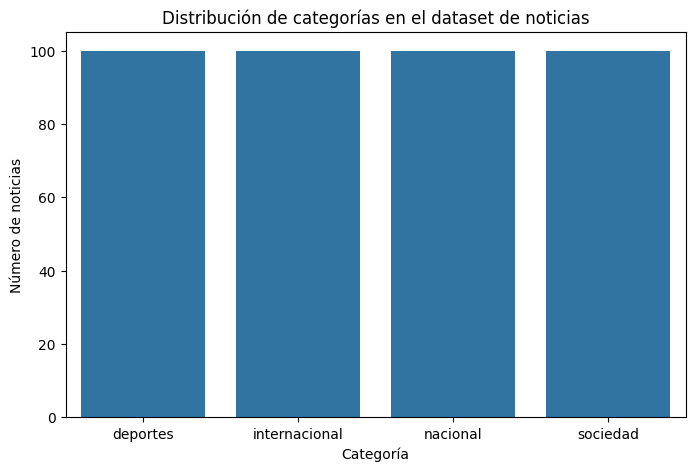

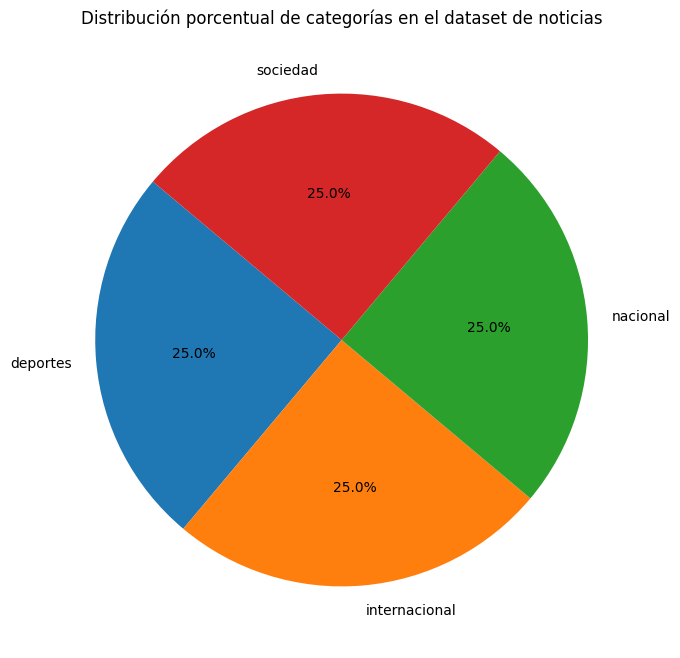

In [3]:
spam_df = pd.read_csv(SPAM_DATASET)

# Muestra total de registros
print("Número total de registros en el dataset:", spam_df.shape[0])

# Muestra las columnas del dataset
print("Columnas del dataset:", spam_df.columns.tolist())

# Muestra las primeras filas del dataset y la distribución de categorías
display(spam_df)
print("Distribución por categorías:")
print(spam_df['Categoría'].value_counts())

# Calculamos el porcentaje de cada categoría
total_registros = spam_df.shape[0]
distribucion_porcentaje = (spam_df['Categoría'].value_counts() / total_registros) * 100
print("Distribución porcentual por categorías:")
print(distribucion_porcentaje)

#grafica de barras de la distribución de categorías
plt.figure(figsize=(8, 5))
sns.countplot(data=spam_df, x='Categoría', order=spam_df['Categoría'].value_counts().index)
plt.title('Distribución de categorías en el dataset de noticias')
plt.xlabel('Categoría')
plt.ylabel('Número de noticias')
plt.show()

#grafico de pastel de la distribución de categorías
plt.figure(figsize=(8, 8))
spam_df['Categoría'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Distribución porcentual de categorías en el dataset de noticias')
plt.ylabel('')
plt.show()

In [4]:
# buscar duplicados en el dataset, mismo título y mismo cuerpo
duplicados = spam_df.duplicated(subset=['Titular', 'Cuerpo'], keep=False)
print("Número de registros duplicados (mismo Titular y cuerpo):", duplicados.sum())
display(spam_df[duplicados].sort_values(by=['Titular', 'Cuerpo']))

# el que esta duplicado, cuantas veces aparece
duplicados_df = spam_df[duplicados]
conteo_duplicados = duplicados_df.groupby(['Titular', 'Cuerpo']).size().reset_index(name='Conteo')
print("Conteo de registros duplicados únicos:", conteo_duplicados.shape[0])
display(conteo_duplicados)



Número de registros duplicados (mismo Titular y cuerpo): 80


,Titular,Cuerpo,Categoría
237,El Congreso aprueba ley de protección de datos...,La nueva legislación impone requisitos estrict...,nacional
277,El Congreso aprueba ley de protección de datos...,La nueva legislación impone requisitos estrict...,nacional
241,El Senado debate reforma del sistema de salud ...,Se inició un debate sobre la reestructuración ...,nacional
281,El Senado debate reforma del sistema de salud ...,Se inició un debate sobre la reestructuración ...,nacional
372,El auge del comercio justo en la producción te...,Las cooperativas artesanales están certificánd...,sociedad
...,...,...,...
280,Política ambiental: nueva ley de protección de...,El gobierno aprobó una legislación que prohíbe...,nacional
242,Presidente anuncia plan de digitalización admi...,Hoy se anunció una inversión de 80 mil millone...,nacional
282,Presidente anuncia plan de digitalización admi...,Hoy se anunció una inversión de 80 mil millone...,nacional
238,Presidente firma decreto sobre control de prec...,Hoy se aprobó una medida temporal que limita e...,nacional


Conteo de registros duplicados únicos: 34


,Titular,Cuerpo,Conteo
0,El Congreso aprueba ley de protección de datos...,La nueva legislación impone requisitos estrict...,2
1,El Senado debate reforma del sistema de salud ...,Se inició un debate sobre la reestructuración ...,2
2,El auge del comercio justo en la producción te...,Las cooperativas artesanales están certificánd...,2
3,El auge del coworking para startups tecnológicas,Las nuevas plataformas de trabajo colaborativo...,2
4,El auge del turismo comunitario como motor de ...,Las iniciativas de ecoturismo generan ingresos...,2
5,"El campeón mundial de esgrima, Kim Min-Jae, ga...",El coreano venció a el argentino Gabriel Yunes...,3
6,"El campeón mundial de gimnasia, Kohei Uchimura...",El japonés venció al italiano Marco Rossi en l...,3
7,"El campeón mundial de salto con pértiga, Arman...",Duplantis superó a Yaroslav Rybakov en la fina...,4
8,"El campeón mundial de salto con pértiga, Renau...",Lavillenie superó a Yaroslav Rybakov en la fin...,2
9,El crecimiento de la economía circular en la i...,Las marcas están reciclando fibras y reutiliza...,2


In [5]:
# hay valores nulos en el dataset
valores_nulos = spam_df.isnull().sum()  
print("Valores nulos por columna:")
print(valores_nulos)


Valores nulos por columna:
Titular      0
Cuerpo       0
Categoría    0
dtype: int64


Estadísticas de longitud del Titular (palabras):
count    400.000000
mean      11.475000
std        2.821218
min        6.000000
25%       10.000000
50%       11.000000
75%       13.000000
max       19.000000
Name: longitud_titular, dtype: float64

Estadísticas de longitud del Cuerpo (palabras):
count    400.000000
mean      24.622500
std        8.495318
min       10.000000
25%       18.000000
50%       24.000000
75%       29.000000
max       70.000000
Name: longitud_cuerpo, dtype: float64


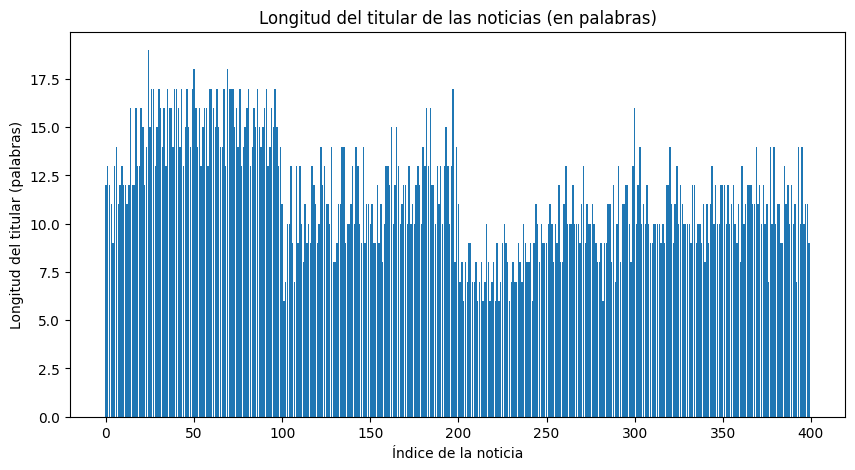

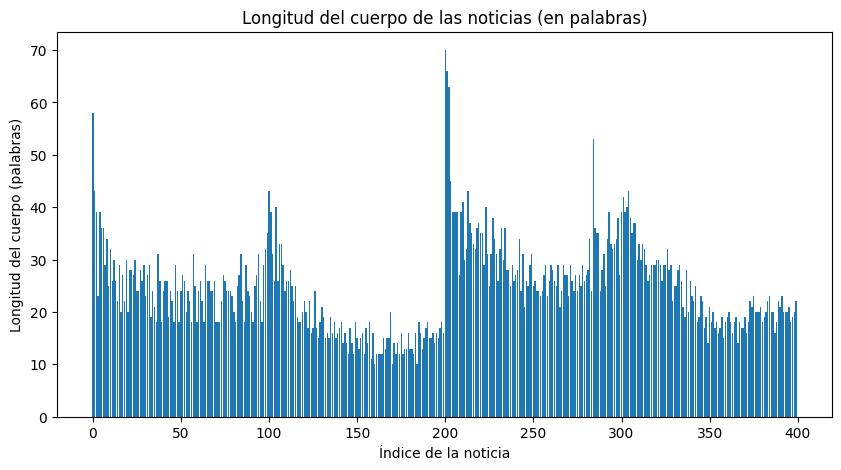

In [6]:
import matplotlib.pyplot as plt

# Longitud mínima, máxima y media del cuerpo y título de las noticias EN PALABRAS
spam_df['longitud_titular'] = spam_df['Titular'].astype(str).str.split().str.len()
spam_df['longitud_cuerpo'] = spam_df['Cuerpo'].astype(str).str.split().str.len()

print("Estadísticas de longitud del Titular (palabras):")
print(spam_df['longitud_titular'].describe())
print("\nEstadísticas de longitud del Cuerpo (palabras):")
print(spam_df['longitud_cuerpo'].describe())

# Gráfico de barras de la longitud del titular (en palabras)
plt.figure(figsize=(10, 5))
plt.bar(spam_df.index, spam_df['longitud_titular'])
plt.xlabel('Índice de la noticia')
plt.ylabel('Longitud del titular (palabras)')
plt.title('Longitud del titular de las noticias (en palabras)')
plt.show()

# Gráfico de barras de la longitud del cuerpo (en palabras)
plt.figure(figsize=(10, 5))
plt.bar(spam_df.index, spam_df['longitud_cuerpo'])
plt.xlabel('Índice de la noticia')
plt.ylabel('Longitud del cuerpo (palabras)')
plt.title('Longitud del cuerpo de las noticias (en palabras)')
plt.show()


In [7]:
# cuerpo más largo en palabras
indice_cuerpo_mas_largo = spam_df['longitud_cuerpo'].idxmax()
cuerpo_mas_largo = spam_df.loc[indice_cuerpo_mas_largo, 'Cuerpo']
num_palabras_cuerpo = spam_df.loc[indice_cuerpo_mas_largo, 'longitud_cuerpo']

print("Cuerpo más largo (índice {}):".format(indice_cuerpo_mas_largo))
print("Número de palabras en el cuerpo:", num_palabras_cuerpo)
print(cuerpo_mas_largo)
print("Categoría del cuerpo más largo:", spam_df.loc[indice_cuerpo_mas_largo, 'Categoría'])
print("\n")

# titular más largo en palabras
indice_titular_mas_largo = spam_df['longitud_titular'].idxmax()
titular_mas_largo = spam_df.loc[indice_titular_mas_largo, 'Titular']
num_palabras_titular = spam_df.loc[indice_titular_mas_largo, 'longitud_titular']

print("Titular más largo (índice {}):".format(indice_titular_mas_largo))
print("Número de palabras en el titular:", num_palabras_titular)
print(titular_mas_largo)
print("Categoría del titular más largo:", spam_df.loc[indice_titular_mas_largo, 'Categoría'])


Cuerpo más largo (índice 200):
Número de palabras en el cuerpo: 70
Tras un intenso debate parlamentario, el Congreso Nacional aprobó hoy una reforma tributaria destinada a aliviar la carga fiscal sobre los hogares de ingresos medios. La ley contempla reducciones en el impuesto sobre la renta para familias con ingresos entre 30 000 y 70 000 euros anuales, además de exenciones parciales para compras de vivienda nueva. Los legisladores argumentan que esta medida fomentará la demanda interna y estimulará la economía.
Categoría del cuerpo más largo: nacional


Titular más largo (índice 24):
Número de palabras en el titular: 19
Los torneos de tenis femenino del WTA celebran el triunfo de Serena Williams en un clásico contra Naomi Osaka
Categoría del titular más largo: deportes


               longitud_titular  longitud_cuerpo
Categoría                                       
deportes                  14.80            25.54
internacional             11.28            17.79
nacional                   8.99            31.49
sociedad                  10.83            23.67


<Figure size 800x500 with 0 Axes>

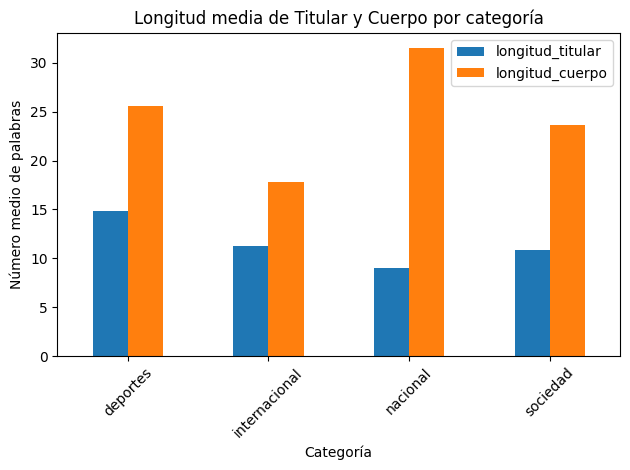

In [8]:
import matplotlib.pyplot as plt

# Agrupar por categoría y calcular la media de palabras
cat_stats = spam_df.groupby('Categoría')[['longitud_titular', 'longitud_cuerpo']].mean()

print(cat_stats)

# Gráfico de barras
plt.figure(figsize=(8, 5))
cat_stats.plot(kind='bar')
plt.xlabel('Categoría')
plt.ylabel('Número medio de palabras')
plt.title('Longitud media de Titular y Cuerpo por categoría')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 800x500 with 0 Axes>

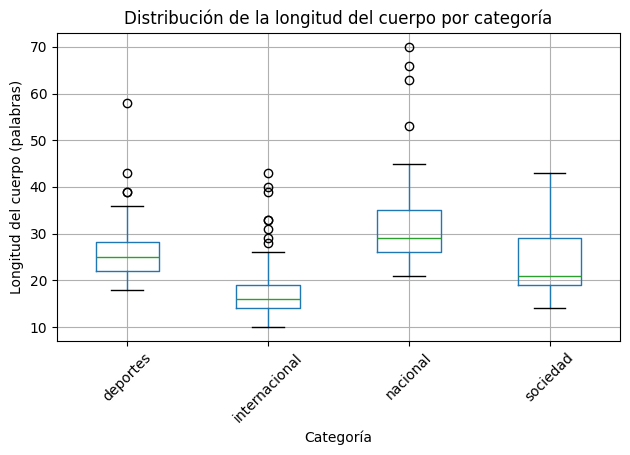

<Figure size 800x500 with 0 Axes>

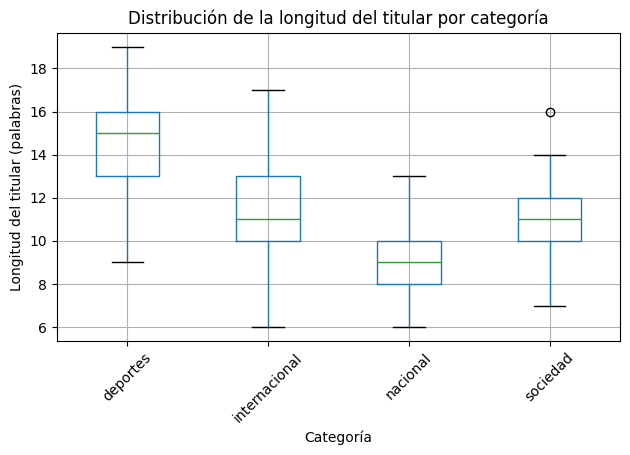

In [9]:
# Boxplot de la longitud del cuerpo por categoría
plt.figure(figsize=(8, 5))
spam_df.boxplot(column='longitud_cuerpo', by='Categoría')
plt.xlabel('Categoría')
plt.ylabel('Longitud del cuerpo (palabras)')
plt.title('Distribución de la longitud del cuerpo por categoría')
plt.suptitle('')  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot de la longitud del titular por categoría
plt.figure(figsize=(8, 5))
spam_df.boxplot(column='longitud_titular', by='Categoría')
plt.xlabel('Categoría')
plt.ylabel('Longitud del titular (palabras)')
plt.title('Distribución de la longitud del titular por categoría')
plt.suptitle('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# similitud de coseno entre titulares y cuerpos de noticias
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(spam_df['Titular'] + " " + spam_df['Cuerpo'])
cosine_sim = cosine_similarity(tfidf_matrix)
print("Matriz de similitud de coseno entre titulares y cuerpos de noticias:")
print(cosine_sim)

Matriz de similitud de coseno entre titulares y cuerpos de noticias:
[[1.         0.09009694 0.10054007 ... 0.03511322 0.0251074  0.02885306]
 [0.09009694 1.         0.07827161 ... 0.02514191 0.02229486 0.02795639]
 [0.10054007 0.07827161 1.         ... 0.04962037 0.04038141 0.05428175]
 ...
 [0.03511322 0.02514191 0.04962037 ... 1.         0.02434465 0.04782593]
 [0.0251074  0.02229486 0.04038141 ... 0.02434465 1.         0.02749584]
 [0.02885306 0.02795639 0.05428175 ... 0.04782593 0.02749584 1.        ]]


In [11]:
# 1. Construir el texto combinado (Titular + Cuerpo)
spam_df["texto_completo"] = spam_df["Titular"].astype(str) + " " + spam_df["Cuerpo"].astype(str)

# 2. Vectorizar con TF-IDF 
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(spam_df["texto_completo"])

# 3. Calcular la matriz de similitud de coseno
cosine_sim = cosine_similarity(tfidf_matrix)
print("Matriz de similitud de coseno entre noticias (shape={}):".format(cosine_sim.shape))

# 4. Buscar pares de noticias near-duplicate según un umbral
umbral = 0.9  
n = cosine_sim.shape[0]
pairs = []

for i in range(n):
    for j in range(i + 1, n):  # solo parte superior de la matriz
        if cosine_sim[i, j] >= umbral:
            pairs.append((i, j, cosine_sim[i, j]))

print(f"\nEncontrados {len(pairs)} pares con similitud >= {umbral}")

# 5. Ordenar pares por similitud (de mayor a menor) y mostrar los primeros
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

for i, j, sim in pairs_sorted[:10]:  
    print("\n---")
    print(f"Índices: {i} - {j} | similitud: {sim:.3f}")
    print("Titular 1:", spam_df.loc[i, "Titular"])
    print("Titular 2:", spam_df.loc[j, "Titular"])
    print("Cuerpo 1:", spam_df.loc[i, "Cuerpo"])
    print("Cuerpo 2:", spam_df.loc[j, "Cuerpo"])


Matriz de similitud de coseno entre noticias (shape=(400, 400)):

Encontrados 68 pares con similitud >= 0.9

---
Índices: 81 - 91 | similitud: 1.000
Titular 1: Los torneos de fútbol juvenil de Grecia celebran su primer campeonato mundial masculino tras vencer a Italia
Titular 2: Los torneos de fútbol juvenil de Grecia celebran su primer campeonato mundial masculino tras vencer a Italia
Cuerpo 1: Los griegos lograron la remontada final, gracias al gol decisivo del jugador Nikos Papadopoulos en el último minuto.
Cuerpo 2: Los griegos lograron la remontada final, gracias al gol decisivo del jugador Nikos Papadopoulos en el último minuto.

---
Índices: 379 - 395 | similitud: 1.000
Titular 1: La relevancia de los foros ciudadanos en la toma de decisiones sobre transporte público
Titular 2: La relevancia de los foros ciudadanos en la toma de decisiones sobre transporte público
Cuerpo 1: Los residentes participan activamente en consultas públicas que determinan rutas y horarios, aumentando la

# Limpieza del dataset, eliminación de duplicados

In [12]:
# Eliminación de duplicados basados en Titular y Cuerpo
# impirmimos el número de registros antes y después de eliminar duplicados y guardar el dataset limpio en un nuevo archivo CSV
print("Número de registros antes de eliminar duplicados:", spam_df.shape[0])
spam_df_cleaned = spam_df.drop_duplicates(subset=['Titular', 'Cuerpo'], keep='first').reset_index(drop=True)
print("Número de registros después de eliminar duplicados:", spam_df_cleaned.shape[0])
spam_df_cleaned.to_csv("news_dataset_cleaned.csv", index=False)

Número de registros antes de eliminar duplicados: 400
Número de registros después de eliminar duplicados: 354


In [13]:
# buscar duplicados en el dataset, mismo título y mismo cuerpo
duplicados = spam_df_cleaned.duplicated(subset=['Titular', 'Cuerpo'], keep=False)
print("Número de registros duplicados (mismo Titular y cuerpo) después de limpieza:", duplicados.sum()) 
display(spam_df_cleaned[duplicados].sort_values(by=['Titular', 'Cuerpo']))

# el que esta duplicado, cuantas veces aparece
duplicados_df = spam_df_cleaned[duplicados]
conteo_duplicados = duplicados_df.groupby(['Titular', 'Cuerpo']).size().reset_index(name='Conteo')
print("Conteo de registros duplicados únicos:", conteo_duplicados.shape[0])
display(conteo_duplicados)

Número de registros duplicados (mismo Titular y cuerpo) después de limpieza: 0


,Titular,Cuerpo,Categoría,longitud_titular,longitud_cuerpo,texto_completo


Conteo de registros duplicados únicos: 0


,Titular,Cuerpo,Conteo


Distribución por categorías después de limpieza:
Categoría
internacional    99
nacional         93
sociedad         88
deportes         74
Name: count, dtype: int64


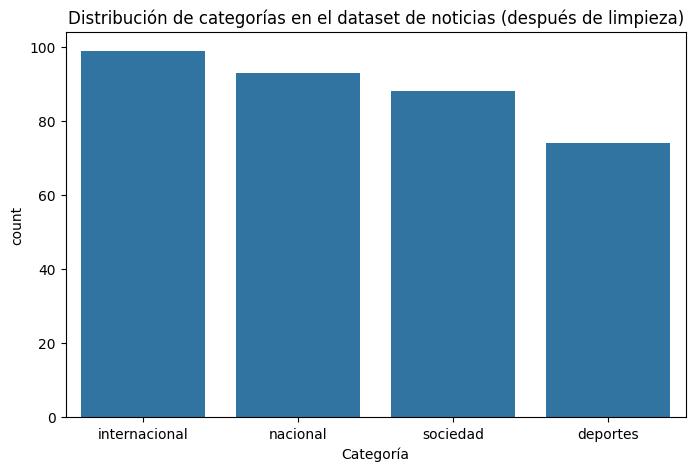

In [14]:
# distribución por categorías después de limpieza
print("Distribución por categorías después de limpieza:")
print(spam_df_cleaned['Categoría'].value_counts())

#grafica de barras de la distribución de categorías después de limpieza
plt.figure(figsize=(8, 5))
sns.countplot(data=spam_df_cleaned, x='Categoría', order=spam_df_cleaned['Categoría'].value_counts().index)
plt.title('Distribución de categorías en el dataset de noticias (después de limpieza)')
plt.show()

In [15]:
SPAM_DATASET_CLEANED= r"C:\Users\USUARIO\Documents\GitHub\tema-4-1-clasificacion-de-textos-y-deteccion-de-spam-maria2332\Clasificación Noticias\news_dataset_cleaned.csv"
RANDOM_SEED = 202510                            # Semilla para la reproducibilidad de los resultados (No tocar para poder comparar resultados)

## Definicion del conjunto de entrenamiento y pruebas

In [16]:
spam_df = pd.read_csv(SPAM_DATASET_CLEANED)

def split_dataset(dataset= None, stratify_column= None, test_size=0.2, random_state=RANDOM_SEED):
    """ 
    Divide el dataset en conjuntos de entrenamiento y test.
    Mantiene la proporción de registros (test_size) dependiendo del valor del valor del parámetro stratify_column.

    Parámetros:
        dataset (DataFrame): El DataFrame completo a dividir.
        stratify_column (str): El nombre de la columna para estratificar.
        test_size (float): La proporción del dataset que se destina a test.
        random_state (int): Semilla para la reproducibilidad.
    """
    train_df, test_df = train_test_split(
        dataset, 
        test_size=test_size, 
        stratify= dataset[stratify_column], 
        random_state=RANDOM_SEED
    )
    return train_df, test_df


stratify_column= "Categoría"

# Genera los conjuntos de entrenamiento y test
train_df, test_df = split_dataset(
    dataset= spam_df,
    test_size= 0.2, # Especificamos un 20% del total del dataset original para el conjunto de pruebas.
    stratify_column= stratify_column
)
# Muestra los datasets generados para entrenamiento y test.
print("\nConjunto de Entrenamiento:")
print(train_df[stratify_column].value_counts())
display(train_df)
print("\nConjunto de Test:")
print(test_df[stratify_column].value_counts())
display(test_df)


Conjunto de Entrenamiento:
Categoría
internacional    79
nacional         74
sociedad         71
deportes         59
Name: count, dtype: int64


,Titular,Cuerpo,Categoría,longitud_titular,longitud_cuerpo,texto_completo
193,Presidente firma decreto sobre protección de d...,El presidente firmó un decreto que reforzará l...,nacional,8,35,Presidente firma decreto sobre protección de d...
227,Presidente firma decreto sobre reforma del sis...,Hoy se aprobó una medida que modifica el métod...,nacional,8,23,Presidente firma decreto sobre reforma del sis...
177,El Senado debate la reforma del sistema judicial,El Senado inició el debate sobre una propuesta...,nacional,8,39,El Senado debate la reforma del sistema judici...
111,La ONU convoca una cumbre global sobre el come...,"Los países discuten regulaciones, protección d...",internacional,10,18,La ONU convoca una cumbre global sobre el come...
318,El aumento del uso de energías renovables en h...,Los residentes están adoptando paneles solares...,sociedad,10,20,El aumento del uso de energías renovables en h...
...,...,...,...,...,...,...
45,"El campeón mundial de salto con pértiga, Arman...",Duplantis superó a Yaroslav Rybakov en la fina...,deportes,15,22,"El campeón mundial de salto con pértiga, Arman..."
42,La selección de fútbol de Colombia gana su pri...,"Los Cafeteros vencieron a España en la final, ...",deportes,14,26,La selección de fútbol de Colombia gana su pri...
60,La selección de hockey sobre hielo de Finlandi...,Finlandia se coronó campeón con un gol de Jere...,deportes,17,24,La selección de hockey sobre hielo de Finlandi...
220,Ministerio de Ciencia expone plan de investiga...,El ministro anunció un proyecto para investiga...,nacional,10,25,Ministerio de Ciencia expone plan de investiga...



Conjunto de Test:
Categoría
internacional    20
nacional         19
sociedad         17
deportes         15
Name: count, dtype: int64


,Titular,Cuerpo,Categoría,longitud_titular,longitud_cuerpo,texto_completo
26,La selección de hockey sobre hielo de Canadá g...,Canadá se coronó campeón con un gol de Connor ...,deportes,17,24,La selección de hockey sobre hielo de Canadá g...
148,El gobierno de Brasil anuncia un plan de desar...,"Se incluirá la construcción de parques verdes,...",internacional,11,12,El gobierno de Brasil anuncia un plan de desar...
314,La importancia de la educación inclusiva para ...,Los programas de inclusión escolar han mejorad...,sociedad,10,19,La importancia de la educación inclusiva para ...
43,El equipo de rugby de Francia gana su primer t...,"Las Les Bleues lograron la remontada final, gr...",deportes,17,19,El equipo de rugby de Francia gana su primer t...
203,El presidente firma decreto sobre seguridad ci...,Hoy se aprobó un nuevo marco legal para fortal...,nacional,7,26,El presidente firma decreto sobre seguridad ci...
...,...,...,...,...,...,...
50,Los torneos de tenis femenino del WTA celebran...,Williams ganó el título de Australian Open 202...,deportes,16,27,Los torneos de tenis femenino del WTA celebran...
286,El papel de la educación sexual integral en la...,Una nueva iniciativa escolar incorpora el tema...,sociedad,14,30,El papel de la educación sexual integral en la...
73,La selección femenina de fútbol de Japón gana ...,Las japonesas vencieron a Alemania en la final...,deportes,14,35,La selección femenina de fútbol de Japón gana ...
136,El gobierno de Turquía anuncia un plan para me...,Se propone un tratado bilateral que incluya co...,internacional,15,12,El gobierno de Turquía anuncia un plan para me...


## Funcion de preprocesamiento del texto

In [17]:
def preprocesar_documento(documento):
    """
    Función para preprocesar un documento individual
    
    Args:
        documento (str): Texto del documento a preprocesar
    
    Returns:
        list: Lista de tokens normalizados para el texto a preprocesar.
    """
    documento = documento.lower()
    
    # Eliminar signos de puntuación usando expresiones regulares
    # documento = re.sub(r'[^\w\s]', '', documento)
    
    # Tokenizar usando NLTK
    tokens = word_tokenize(documento, language='spanish')

    # Eliminación de puntuación y stopwords
    stop_words = set(stopwords.words("spanish"))
    tokens_limpios = [t for t in tokens if t not in string.punctuation and t not in stop_words]
    
    # Filtrar tokens que no sean alfabéticos (eliminar números)
    tokens_filtrados = [token for token in tokens_limpios if token.isalpha()]

    # Lamtización usando spaCy
    doc_spacy = nlp(" ".join(tokens_filtrados))
    tokens_lemmatizados = [token.lemma_ for token in doc_spacy] 
    
    return tokens_lemmatizados

In [18]:
train_documentos_procesados = []
for i, fila in train_df.iterrows():
    texto_combinado = f"{fila['Titular']} {fila['Cuerpo']}"
    tokens = preprocesar_documento(texto_combinado)
    train_documentos_procesados.append(" ".join(tokens))

# Número de documentos de entrenamiento procesados
print(f"Número de documentos de entrenamiento procesados: {len(train_documentos_procesados)}")
print(f"Documentos de entrenamiento procesados: {train_documentos_procesados[:3]}...")

Número de documentos de entrenamiento procesados: 283
Documentos de entrenamiento procesados: ['presidente firma decreto protección dato personal presidente firmar decreto reforzar norma protección dato personal entidad público alinear él reglamento general protección dato rgpd medida incluir sanción severo incumplimiento', 'presidente firma decreto reforma sistema electoral hoy aprobar medida modifico método asignación escaño reflejar mejor proporcionalidad voto representación parlamentario', 'senado debate reforma sistema judicial senado iniciar debate propuesto reforma buscar modernizar sistema judicial reducir plazo procesal caso civil penal defensor argumentar eficiencia crítico temer pérdido garantía procesal víctima']...


In [19]:
# Crea el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer (
    stop_words=None, 
    ngram_range= (1,1),
    analyzer='word',
    max_df=0.5,
    min_df=1,
    max_features= None
)

X_train_tfidf_full = tfidf_vectorizer.fit_transform(raw_documents=train_documentos_procesados)

# Muestra el tamaño de la matriz TF-IDF
print("Tamaño de la matriz TF-IDF:", X_train_tfidf_full.shape)
# Muestra algunas características del vectorizador TF-IDF
print("Número de características (palabras únicas) en el vocabulario TF-IDF:", len(tfidf_vectorizer.vocabulary_))
print("Características (primeras 10 palabras TF-IDF):", list(tfidf_vectorizer.vocabulary_.keys())[:10])

Tamaño de la matriz TF-IDF: (283, 1818)
Número de características (palabras únicas) en el vocabulario TF-IDF: 1818
Características (primeras 10 palabras TF-IDF): ['presidente', 'firma', 'decreto', 'protección', 'dato', 'personal', 'firmar', 'reforzar', 'norma', 'entidad']


## Entrenamiento del modelo NB por conteo

In [26]:
# 1. Vectorizamos los documentos de entrenamiento usando CountVectorizer
vectorizer_count = CountVectorizer()
X_train_counts_full = vectorizer_count.fit_transform(train_documentos_procesados)

# 2. Obtenemos las clases y definimos priors uniformes (todas las clases igual de probables)
y_train = train_df['Categoría'].values
clases_unicas = np.unique(y_train)                    # mismas clases y mismo orden que usará NB
n_clases = len(clases_unicas)
priors_uniformes = np.ones(n_clases) / n_clases       # p(c) = 1 / nº de clases

print("Clases detectadas:", clases_unicas)
print("Priors uniformes usadas:", priors_uniformes)

# 3. Entrenamos el clasificador Naive Bayes usando los datos vectorizados por conteo
clf_count_full = MultinomialNB(
    alpha=1.0,
    force_alpha=True,
    fit_prior=False,            # no aprender priors desde los datos
    class_prior=priors_uniformes
)

clf_count_full.fit(X_train_counts_full, y_train)

# 4. Mostramos algunos aspectos del modelo entrenado
print("\nClases del modelo NB por conteo entrenado:", clf_count_full.classes_)

# 5. Muestra top frecuencias del modelo por conteo
feature_counts = np.asarray(X_train_counts_full.sum(axis=0)).flatten()
feature_names = vectorizer_count.get_feature_names_out()
feature_freq = list(zip(feature_names, feature_counts))  # Lista de tuplas (palabra, frecuencia)
feature_freq.sort(key=lambda x: x[1], reverse=True)

print("\nTop 10 palabras más frecuentes (modelo por conteo)")
print("------------------------------")
for word, freq in feature_freq[:10]:
    print(f"{word}: {freq}")

print("\nTop 10 palabras menos frecuentes (modelo por conteo)")
print("------------------------------")
for word, freq in feature_freq[-10:]:
    print(f"{word}: {freq}")

print("Clases:", clf_count_full.classes_)
print("log-priors:", clf_count_full.class_log_prior_)



Clases detectadas: ['deportes' 'internacional' 'nacional' 'sociedad']
Priors uniformes usadas: [0.25 0.25 0.25 0.25]

Clases del modelo NB por conteo entrenado: ['deportes' 'internacional' 'nacional' 'sociedad']

Top 10 palabras más frecuentes (modelo por conteo)
------------------------------
anunciar: 59
mundial: 54
ganar: 45
plan: 45
público: 44
final: 43
vencer: 43
nuevo: 40
presidente: 39
programa: 38

Top 10 palabras menos frecuentes (modelo por conteo)
------------------------------
yvonne: 1
zhonghua: 1
ámbito: 1
ángel: 1
árida: 1
épica: 1
épico: 1
índice: 1
öberg: 1
único: 1
Clases: ['deportes' 'internacional' 'nacional' 'sociedad']
log-priors: [-1.38629436 -1.38629436 -1.38629436 -1.38629436]


## Entrenamiento del modelo tf-idf

In [27]:
# 1. Vectorizamos los documentos de entrenamiento usando TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf_full = tfidf_vectorizer.fit_transform(train_documentos_procesados)

# 2. Obtenemos y_train y definimos priors uniformes para las clases
y_train = train_df['Categoría'].values
clases_unicas = np.unique(y_train)
n_clases = len(clases_unicas)
priors_uniformes = np.ones(n_clases) / n_clases   # todas las clases igual de probables

print("Clases detectadas:", clases_unicas)
print("Priors uniformes usadas:", priors_uniformes)

# 3. Entrenamos el clasificador NB usando TF-IDF y priors uniformes
clf_tfidf_full = MultinomialNB(
    alpha=1.0,
    force_alpha=True,
    fit_prior=False,             # no aprende priors desde los datos
    class_prior=priors_uniformes
)

clf_tfidf_full.fit(X_train_tfidf_full, y_train)

# 4. Mostramos algunos aspectos del modelo entrenado.
print("\nClases del modelo NB por TF-IDF entrenado:", clf_tfidf_full.classes_)
print("log-priors:", clf_tfidf_full.class_log_prior_)

# 5. Muestra "top frecuencias" (en realidad suma de pesos TF-IDF)
feature_counts = np.asarray(X_train_tfidf_full.sum(axis=0)).flatten()
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_freq = list(zip(feature_names, feature_counts))  # Lista de tuplas (palabra, peso total)
feature_freq.sort(key=lambda x: x[1], reverse=True)

print("\nTop 10 palabras más 'fuertes' (modelo TF-IDF)")
print("------------------------------")
for word, freq in feature_freq[:10]:
    print(f"{word}: {freq}")

print("\nTop 10 palabras menos 'fuertes' (modelo TF-IDF)")
print("------------------------------")
for word, freq in feature_freq[-10:]:
    print(f"{word}: {freq}")

Clases detectadas: ['deportes' 'internacional' 'nacional' 'sociedad']
Priors uniformes usadas: [0.25 0.25 0.25 0.25]

Clases del modelo NB por TF-IDF entrenado: ['deportes' 'internacional' 'nacional' 'sociedad']
log-priors: [-1.38629436 -1.38629436 -1.38629436 -1.38629436]

Top 10 palabras más 'fuertes' (modelo TF-IDF)
------------------------------
anunciar: 7.784094450297212
mundial: 6.730774059231602
plan: 6.393219626259103
público: 5.966844207483248
presidente: 5.679889710403155
vencer: 5.57646456569857
final: 5.552191971747867
reducir: 5.351610864574169
ganar: 5.3466157718645935
nuevo: 5.294926184943772

Top 10 palabras menos 'fuertes' (modelo TF-IDF)
------------------------------
cifra: 0.16599571172907696
conferencia: 0.16599571172907696
controlar: 0.16599571172907696
explicar: 0.16599571172907696
ligeramente: 0.16599571172907696
ministra: 0.16599571172907696
plantear: 0.16599571172907696
prensa: 0.16599571172907696
subida: 0.16599571172907696
tipos: 0.16599571172907696


In [28]:
# Preprocesamos los documentos del conjunto de test
test_documentos_procesados = []
for i, fila in test_df.iterrows():
    texto_combinado = f"{fila['Titular']} {fila['Cuerpo']}"
    tokens = preprocesar_documento(texto_combinado)
    test_documentos_procesados.append(" ".join(tokens))

# Número de documentos de test procesados
print(f"Número de documentos de test procesados: {len(test_documentos_procesados)}")
print(f"Documentos de test procesados: {test_documentos_procesados[:3]}...")  # Muestra los primeros 3 documentos procesados


Número de documentos de test procesados: 71
Documentos de test procesados: ['selección hockey hielo canadá ganar copa mundial tras vencer rusia canadá coronar campeón gol connor mcdavid minuto victoria recibido entusiasmo aficionado canadiense', 'gobierno brasil anunciar plan desarrollo urbano sostenible incluir construcción parqu verde transporte público vivienda asequible', 'importancia educación inclusivo estudiante discapacidad programa inclusión escolar mejorado rendimiento académico integración social alumno necesidad especial']...


## Evaluacion del modelo NB por conteo

In [29]:
# Evaluamos el modelo NB por conteo
X_test_counts_full = vectorizer_count.transform(test_documentos_procesados)
y_test_pred_count_full = clf_count_full.predict(X_test_counts_full)
accuracy_count_full = accuracy_score(test_df['Categoría'], y_test_pred_count_full)
print(f"Exactitud del modelo NB por conteo en el conjunto de test: {accuracy_count_full:.4f}")

# Evaluamos el modelo NB por TF-IDF
X_test_tfidf_full = tfidf_vectorizer.transform(test_documentos_procesados)
y_test_pred_tfidf_full = clf_tfidf_full.predict(X_test_tfidf_full)
accuracy_tfidf_full = accuracy_score(test_df['Categoría'], y_test_pred_tfidf_full)
print(f"Exactitud del modelo NB por TF-IDF en el conjunto de test: {accuracy_tfidf_full:.4f}")


Exactitud del modelo NB por conteo en el conjunto de test: 0.9859
Exactitud del modelo NB por TF-IDF en el conjunto de test: 0.9577


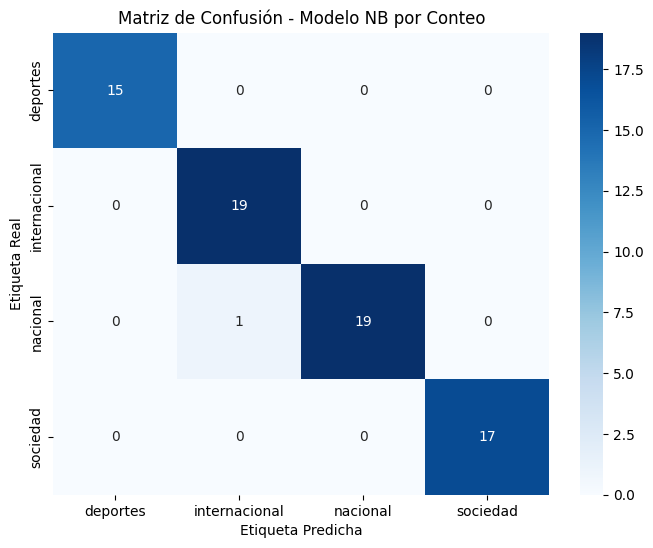

In [30]:
# Calcula y muestra la matriz de confusión para el modelo NB por conteo
confusion_mat_count_full = confusion_matrix(test_df['Categoría'], y_test_pred_count_full)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_count_full.T, annot=True, fmt="d", cmap="Blues",
            xticklabels=clf_count_full.classes_,
            yticklabels=clf_count_full.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión - Modelo NB por Conteo')
plt.show()


In [31]:
# Muestra el resto de métricas de evaluación para el modelo NB por conteo
print("Métricas de evaluación para el modelo NB por conteo:")
print(classification_report(
    test_df['Categoría'], 
    y_test_pred_count_full, 
    target_names=clf_count_full.classes_, 
    zero_division=0, 
    digits=4
))


Métricas de evaluación para el modelo NB por conteo:
               precision    recall  f1-score   support

     deportes     1.0000    1.0000    1.0000        15
internacional     1.0000    0.9500    0.9744        20
     nacional     0.9500    1.0000    0.9744        19
     sociedad     1.0000    1.0000    1.0000        17

     accuracy                         0.9859        71
    macro avg     0.9875    0.9875    0.9872        71
 weighted avg     0.9866    0.9859    0.9859        71



In [32]:
# Cálculo de precisión, recall y F1-score con diferentes promedios
precision_count_full_macro = precision_score(test_df['Categoría'], y_test_pred_count_full, average='macro', zero_division=0)
recall_count_full_macro = recall_score(test_df['Categoría'], y_test_pred_count_full, average='macro', zero_division=0)
f1_count_full_macro = f1_score(test_df['Categoría'], y_test_pred_count_full, average='macro', zero_division=0)
print(f"Macro Average - Precision: {precision_count_full_macro:.4f}, Recall: {recall_count_full_macro:.4f}, F1-score: {f1_count_full_macro:.4f}")

precision_count_full_micro = precision_score(test_df['Categoría'], y_test_pred_count_full, average='micro', zero_division=0)
recall_count_full_micro = recall_score(test_df['Categoría'], y_test_pred_count_full, average='micro', zero_division=0)
f1_count_full_micro = f1_score(test_df['Categoría'], y_test_pred_count_full, average='micro', zero_division=0)
print(f"Micro Average - Precision: {precision_count_full_micro:.4f}, Recall: {recall_count_full_micro:.4f}, F1-score: {f1_count_full_micro:.4f}")

precision_count_full_weighted = precision_score(test_df['Categoría'], y_test_pred_count_full, average='weighted', zero_division=0)
recall_count_full_weighted = recall_score(test_df['Categoría'], y_test_pred_count_full, average='weighted', zero_division=0)
f1_count_full_weighted = f1_score(test_df['Categoría'], y_test_pred_count_full, average='weighted', zero_division=0)
print(f"Weighted Average - Precision: {precision_count_full_weighted:.4f}, Recall: {recall_count_full_weighted:.4f}, F1-score: {f1_count_full_weighted:.4f}")


Macro Average - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9872
Micro Average - Precision: 0.9859, Recall: 0.9859, F1-score: 0.9859
Weighted Average - Precision: 0.9866, Recall: 0.9859, F1-score: 0.9859


In [33]:
# Muestra los documentos mal clasificados por el modelo NB por conteo
test_df['Predicción'] = y_test_pred_count_full
misclassified_count_full = test_df[test_df['Categoría'] != test_df['Predicción']]
display(misclassified_count_full[['Titular', 'Cuerpo', 'Categoría', 'Predicción']])


,Titular,Cuerpo,Categoría,Predicción
94,El presidente de Pakistán anuncia la reforma e...,La iniciativa busca mejorar la calidad de la e...,internacional,nacional


## Evaluacion del modelo tf-idf

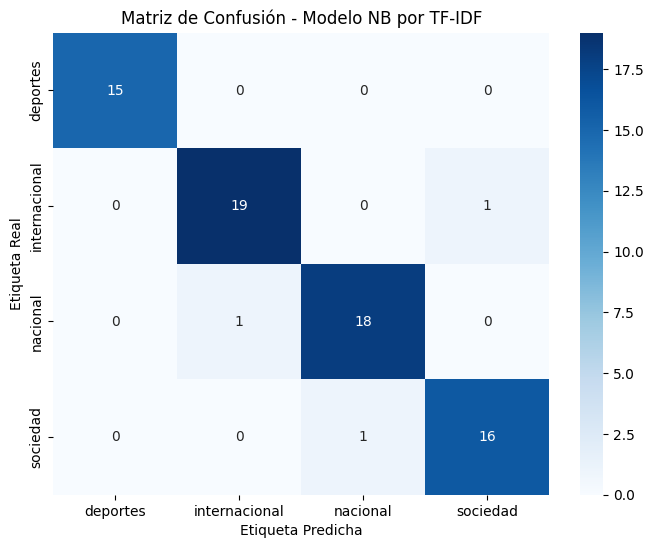

In [34]:
# Calcula y muestra la matriz de confusión para el modelo NB por TF-IDF
confusion_mat_tfidf_full = confusion_matrix(test_df['Categoría'], y_test_pred_tfidf_full)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_tfidf_full.T, annot=True, fmt="d", cmap="Blues",
            xticklabels=clf_tfidf_full.classes_,
            yticklabels=clf_tfidf_full.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión - Modelo NB por TF-IDF')
plt.show()


In [35]:
# Muestra el reporte de clasificación para el modelo NB por TF-IDF
print("Métricas de evaluación para el modelo NB por TF-IDF:")
print(classification_report(
    test_df['Categoría'],
    y_test_pred_tfidf_full,
    target_names=clf_tfidf_full.classes_,
    zero_division=0,
    digits=4
))


Métricas de evaluación para el modelo NB por TF-IDF:
               precision    recall  f1-score   support

     deportes     1.0000    1.0000    1.0000        15
internacional     0.9500    0.9500    0.9500        20
     nacional     0.9474    0.9474    0.9474        19
     sociedad     0.9412    0.9412    0.9412        17

     accuracy                         0.9577        71
    macro avg     0.9596    0.9596    0.9596        71
 weighted avg     0.9577    0.9577    0.9577        71



In [36]:
# Cálculo de precisión, recall y F1-score con diferentes promedios para NB por TF-IDF

precision_tfidf_full_macro = precision_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                             average='macro', zero_division=0)
recall_tfidf_full_macro = recall_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                       average='macro', zero_division=0)
f1_tfidf_full_macro = f1_score(test_df['Categoría'], y_test_pred_tfidf_full,
                               average='macro', zero_division=0)
print(f"Macro Average - Precision: {precision_tfidf_full_macro:.4f}, Recall: {recall_tfidf_full_macro:.4f}, F1-score: {f1_tfidf_full_macro:.4f}")

precision_tfidf_full_micro = precision_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                             average='micro', zero_division=0)
recall_tfidf_full_micro = recall_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                       average='micro', zero_division=0)
f1_tfidf_full_micro = f1_score(test_df['Categoría'], y_test_pred_tfidf_full,
                               average='micro', zero_division=0)
print(f"Micro Average - Precision: {precision_tfidf_full_micro:.4f}, Recall: {recall_tfidf_full_micro:.4f}, F1-score: {f1_tfidf_full_micro:.4f}")

precision_tfidf_full_weighted = precision_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                                average='weighted', zero_division=0)
recall_tfidf_full_weighted = recall_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                          average='weighted', zero_division=0)
f1_tfidf_full_weighted = f1_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                  average='weighted', zero_division=0)
print(f"Weighted Average - Precision: {precision_tfidf_full_weighted:.4f}, Recall: {recall_tfidf_full_weighted:.4f}, F1-score: {f1_tfidf_full_weighted:.4f}")


Macro Average - Precision: 0.9596, Recall: 0.9596, F1-score: 0.9596
Micro Average - Precision: 0.9577, Recall: 0.9577, F1-score: 0.9577
Weighted Average - Precision: 0.9577, Recall: 0.9577, F1-score: 0.9577


In [37]:
test_df['Predicción_TFIDF'] = y_test_pred_tfidf_full
misclassified_tfidf_full = test_df[test_df['Categoría'] != test_df['Predicción_TFIDF']]

display(misclassified_tfidf_full[['Titular', 'Cuerpo', 'Categoría', 'Predicción_TFIDF']])


,Titular,Cuerpo,Categoría,Predicción_TFIDF
320,El impacto del cambio climático en la segurida...,Los patrones climáticos alterados han llevado ...,sociedad,internacional
94,El presidente de Pakistán anuncia la reforma e...,La iniciativa busca mejorar la calidad de la e...,internacional,nacional
181,Autoridades locales critican falta de apoyo es...,Algunas autoridades municipales denunciaron la...,nacional,sociedad


# Random forest para clasificación de noticias periodísticas

In [38]:
# Crear y entrenar el modelo de Random Forest
random_forest = RandomForestClassifier (
    n_estimators= 100,              # Número de árboles en el bosque
    criterion= 'gini',              # Criterio de división de nodos.
    max_features= 'sqrt',           # Número de características a considerar en cada división.
    max_depth= None,                # Profundidad máxima del árbol.
    min_samples_split =4,           # Mínimo de muestras para dividir un nodo.
    min_samples_leaf= 2,            # Mínimo de muestras en una hoja.
    min_impurity_decrease= 0.01,    # Mínima disminución de impureza para dividir un nodo.
    class_weight= 'balanced',       # Manejo del desbalanceo de clases.
    random_state= RANDOM_SEED       # Semilla para la reproducibilidad.
)

random_forest_pipeline = Pipeline(
    steps= [
        ('vectorizer', tfidf_vectorizer),
        ('classifier', random_forest)
    ]
)
random_forest_pipeline.fit(
    train_documentos_procesados,
    train_df['Categoría']
)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        min_impurity_decrease=0.01,
                                        min_samples_leaf=2, min_samples_split=4,
                                        random_state=202510))])

Número de documentos de test procesados: 71
Documentos procesados (muestra): ['selección hockey hielo canadá ganar copa mundial tras vencer rusia canadá coronar campeón gol connor mcdavid minuto victoria recibido entusiasmo aficionado canadiense', 'gobierno brasil anunciar plan desarrollo urbano sostenible incluir construcción parqu verde transporte público vivienda asequible', 'importancia educación inclusivo estudiante discapacidad programa inclusión escolar mejorado rendimiento académico integración social alumno necesidad especial']...

Evaluación del modelo Random Forest en el conjunto de test:
Exactitud (Accuracy): 0.9718
Precisión (Precision - macro): 0.9742
Exhaustividad (Recall - macro): 0.9737
Puntuación F1 (F1 Score - macro): 0.9729

Reporte de clasificación:
               precision    recall  f1-score   support

     deportes       1.00      1.00      1.00        15
internacional       0.95      1.00      0.98        20
     nacional       1.00      0.89      0.94        1

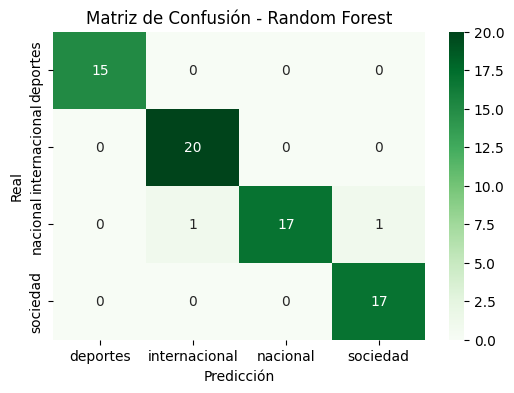

Número de fallos en las predicciones: 2


,Titular,Cuerpo,Categoría,Predicho
181,Autoridades locales critican falta de apoyo es...,Algunas autoridades municipales denunciaron la...,nacional,sociedad
223,Presidente anuncia plan de apoyo a la economía...,Se lanzó una iniciativa estatal para fomentar ...,nacional,internacional


In [39]:
# Preprocesamos los documentos del conjunto de test
test_documentos_procesados = []
for i, fila in test_df.iterrows():
    texto_combinado = f"{fila['Titular']} {fila['Cuerpo']}"
    tokens = preprocesar_documento(texto_combinado)
    test_documentos_procesados.append(" ".join(tokens))

print(f"Número de documentos de test procesados: {len(test_documentos_procesados)}")
print(f"Documentos procesados (muestra): {test_documentos_procesados[:3]}...")


# Predicciones con Random Forest
rf_predictions = random_forest_pipeline.predict(test_documentos_procesados)


# Métricas (macro, porque no es binario)
accuracy = accuracy_score(test_df['Categoría'], rf_predictions)
precision = precision_score(test_df['Categoría'], rf_predictions, average='macro')
recall = recall_score(test_df['Categoría'], rf_predictions, average='macro')
f1 = f1_score(test_df['Categoría'], rf_predictions, average='macro')

print("\nEvaluación del modelo Random Forest en el conjunto de test:")
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"Precisión (Precision - macro): {precision:.4f}")
print(f"Exhaustividad (Recall - macro): {recall:.4f}")
print(f"Puntuación F1 (F1 Score - macro): {f1:.4f}")

print("\nReporte de clasificación:")
print(classification_report(test_df['Categoría'], rf_predictions))

conf_matrix = confusion_matrix(test_df['Categoría'], rf_predictions)

etiquetas = random_forest_pipeline.named_steps['classifier'].classes_

plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=etiquetas,
    yticklabels=etiquetas
)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

fallos = test_df[test_df['Categoría'] != rf_predictions]

print(f"Número de fallos en las predicciones: {len(fallos)}")

fallos = fallos.assign(Predicho = rf_predictions[test_df['Categoría'] != rf_predictions])

display(fallos[['Titular','Cuerpo','Categoría','Predicho']])


In [40]:
# Configuramos el cross validator estratificado
cross_validator = StratifiedKFold(
    n_splits=15,                # Número de folds
    shuffle=True,               # Mezcla aleatoria
    random_state=RANDOM_SEED    # Reproducibilidad
)

# Realiza la validación cruzada sobre Random Forest
scores = cross_val_score(
    estimator=random_forest_pipeline,
    X=train_documentos_procesados,
    y=train_df['Categoría'],    
    cv=cross_validator,
    scoring='accuracy'
)

# Muestra los resultados de la validación cruzada
print("Resultados de la validación cruzada (accuracy) en el conjunto de entrenamiento:")
for fold_idx, score in enumerate(scores):
    print(f" Fold {fold_idx + 1}: {score:.4f}")

print(f" Precisión media: {scores.mean():.4f} ± {scores.std():.4f}")


Resultados de la validación cruzada (accuracy) en el conjunto de entrenamiento:
 Fold 1: 1.0000
 Fold 2: 0.8947
 Fold 3: 1.0000
 Fold 4: 1.0000
 Fold 5: 0.8947
 Fold 6: 0.9474
 Fold 7: 0.8421
 Fold 8: 0.7895
 Fold 9: 0.9474
 Fold 10: 0.9474
 Fold 11: 0.9474
 Fold 12: 0.8947
 Fold 13: 1.0000
 Fold 14: 0.9444
 Fold 15: 0.8889
 Precisión media: 0.9292 ± 0.0599


In [ ]:
# Especificamos los HiperParámetros a evaluar en el GridSearchCV
random_forest_param_grid = {
    # Hiper-Parámetros del RandomForest
    'classifier__n_estimators': [100, 300, 700, 800, 900, 1000],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [20, 50, 100, 150, 200, 250],
    'classifier__class_weight': ['balanced', 'balanced_subsample', None],
    }

cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=RANDOM_SEED)

# Configurar GridSearchCV
random_forest_grid = GridSearchCV(
    estimator=random_forest_pipeline,
    param_grid=random_forest_param_grid,
    cv=10,                  # validación cruzada interna
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    verbose=5
)

# Ejecuta el ajuste del modelo con el GridSearchCV
start_time = pd.Timestamp.now()
random_forest_grid.fit(
    train_documentos_procesados,
    train_df['Categoría']    
)
end_time = pd.Timestamp.now()

print(f"Tiempo de ejecución del GridSearchCV: {(end_time - start_time).total_seconds()} segundos")


# Mostrar los mejores hiper-parámetros encontrados
print("Mejores hiper-parámetros encontrados:")
best_parms = pd.Series(random_forest_grid.best_params_)
display(best_parms)

print(f"Mejor puntuación de validación cruzada: {random_forest_grid.best_score_:.4f}")


Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Tiempo de ejecución del GridSearchCV: 627.149586 segundos
Mejores hiper-parámetros encontrados:


classifier__class_weight    balanced_subsample
classifier__criterion                  entropy
classifier__max_depth                       50
classifier__n_estimators                  1000
dtype: object

Mejor puntuación de validación cruzada: 0.9473



Resultados completos del Grid Search:

Evaluación del mejor modelo en el conjunto de test:
Exactitud (Accuracy): 0.9718
Macro Average - Precision: 0.9742, Recall: 0.9737, F1-score: 0.9729
Micro Average - Precision: 0.9718, Recall: 0.9718, F1-score: 0.9718
Weighted Average - Precision: 0.9733, Recall: 0.9718, F1-score: 0.9714

Reporte de clasificación del mejor modelo:
               precision    recall  f1-score   support

     deportes     1.0000    1.0000    1.0000        15
internacional     0.9524    1.0000    0.9756        20
     nacional     1.0000    0.8947    0.9444        19
     sociedad     0.9444    1.0000    0.9714        17

     accuracy                         0.9718        71
    macro avg     0.9742    0.9737    0.9729        71
 weighted avg     0.9733    0.9718    0.9714        71



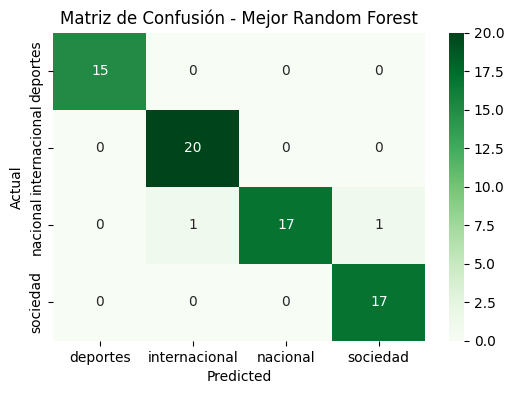

Número de fallos en las predicciones: 2


,Titular,Cuerpo,Categoría,longitud_titular,longitud_cuerpo,texto_completo,Predicción,Predicción_TFIDF,predicted
181,Autoridades locales critican falta de apoyo es...,Algunas autoridades municipales denunciaron la...,nacional,7,27,Autoridades locales critican falta de apoyo es...,nacional,sociedad,sociedad
223,Presidente anuncia plan de apoyo a la economía...,Se lanzó una iniciativa estatal para fomentar ...,nacional,9,25,Presidente anuncia plan de apoyo a la economía...,nacional,nacional,internacional


In [43]:
print("\nResultados completos del Grid Search:")

# Nos quedamos con el mejor modelo encontrado
best_random_forest_model = random_forest_grid.best_estimator_

# Entrenamos el mejor modelo con todo el conjunto de entrenamiento
best_random_forest_model.fit(
    train_documentos_procesados,
    train_df['Categoría']    
)

# Ejecutamos todas las predicciones sobre el conjunto de test.
best_random_forest_predictions = best_random_forest_model.predict(test_documentos_procesados)

# Evaluamos el rendimiento del mejor modelo encontrado
best_accuracy = accuracy_score(test_df['Categoría'], best_random_forest_predictions)

# Para precisión, recall y F1 usamos PROMEDIOS, porque NO hay clase 'spam'
best_precision_macro = precision_score(test_df['Categoría'], best_random_forest_predictions, average='macro', zero_division=0)
best_recall_macro = recall_score(test_df['Categoría'], best_random_forest_predictions, average='macro', zero_division=0)
best_f1_macro = f1_score(test_df['Categoría'], best_random_forest_predictions, average='macro', zero_division=0)

best_precision_micro = precision_score(test_df['Categoría'], best_random_forest_predictions, average='micro', zero_division=0)
best_recall_micro = recall_score(test_df['Categoría'], best_random_forest_predictions, average='micro', zero_division=0)
best_f1_micro = f1_score(test_df['Categoría'], best_random_forest_predictions, average='micro', zero_division=0)

best_precision_weighted = precision_score(test_df['Categoría'], best_random_forest_predictions, average='weighted', zero_division=0)
best_recall_weighted = recall_score(test_df['Categoría'], best_random_forest_predictions, average='weighted', zero_division=0)
best_f1_weighted = f1_score(test_df['Categoría'], best_random_forest_predictions, average='weighted', zero_division=0)

print("\nEvaluación del mejor modelo en el conjunto de test:")
print(f"Exactitud (Accuracy): {best_accuracy:.4f}")
print(f"Macro Average - Precision: {best_precision_macro:.4f}, Recall: {best_recall_macro:.4f}, F1-score: {best_f1_macro:.4f}")
print(f"Micro Average - Precision: {best_precision_micro:.4f}, Recall: {best_recall_micro:.4f}, F1-score: {best_f1_micro:.4f}")
print(f"Weighted Average - Precision: {best_precision_weighted:.4f}, Recall: {best_recall_weighted:.4f}, F1-score: {best_f1_weighted:.4f}")

print("\nReporte de clasificación del mejor modelo:")
print(classification_report(test_df['Categoría'], best_random_forest_predictions, digits=4))

# Muestra la matriz de confusión del mejor modelo
best_conf_matrix = confusion_matrix(test_df['Categoría'], best_random_forest_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(
    best_conf_matrix,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=best_random_forest_model.classes_,
    yticklabels=best_random_forest_model.classes_
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Mejor Random Forest')
plt.show()

# Muestra los documentos mal clasificados
fallos = test_df[test_df['Categoría'] != best_random_forest_predictions]
print(f"Número de fallos en las predicciones: {fallos.shape[0]}")
display(fallos.assign(predicted = best_random_forest_predictions[test_df['Categoría'] != best_random_forest_predictions]))


# SVM para clasificación de noticias periodísticas

In [50]:
# Crea el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    stop_words=None,                # Ya hemos preprocesado los documentos y eliminado stopwords.
    ngram_range=(1,1),              # Unigramas.
    analyzer='word',                # Palabras.
    max_df=0.5,                     # Ignora términos muy frecuentes.
    min_df=1,                       # Términos que aparezcan al menos 1 vez.
    max_features=None               # Sin límite de vocabulario.
)

linear_svc = LinearSVC(
    loss='hinge',                   # Función de pérdida SVM lineal.
    C=1.0,                          # Regularización.
    max_iter=1000,                  # Iteraciones máximas.
    tol=1e-4,                       # Tolerancia.
    random_state=RANDOM_SEED,        # Semilla.
    class_weight='balanced'         # Manejo del desbalanceo de clases.
)

linearsvc_pipeline = Pipeline(
    steps=[
        ('vectorizer', tfidf_vectorizer),
        ('classifier', linear_svc)
    ]
)

linearsvc_pipeline.fit(
    train_documentos_procesados,
    train_df['Categoría']           
)


Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.5)),
                ('classifier',
                 LinearSVC(class_weight='balanced', loss='hinge',
                           random_state=202510))])

Número de documentos de test procesados: 71
Documentos de test procesados: ['selección hockey hielo canadá ganar copa mundial tras vencer rusia canadá coronar campeón gol connor mcdavid minuto victoria recibido entusiasmo aficionado canadiense', 'gobierno brasil anunciar plan desarrollo urbano sostenible incluir construcción parqu verde transporte público vivienda asequible', 'importancia educación inclusivo estudiante discapacidad programa inclusión escolar mejorado rendimiento académico integración social alumno necesidad especial']...

Evaluación del modelo SVM (LinearSVC) en el conjunto de test:
Exactitud (Accuracy): 0.9718
Precisión (Precision): 0.9737
Exhaustividad (Recall): 0.9743
Puntuación F1 (F1 Score): 0.9729

Reporte de clasificación:
               precision    recall  f1-score   support

     deportes       1.00      1.00      1.00        15
internacional       1.00      0.95      0.97        20
     nacional       1.00      0.95      0.97        19
     sociedad       0.

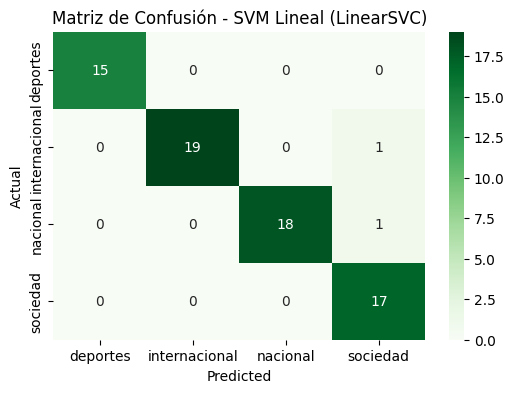

Número de fallos en las predicciones: 2


,Titular,Cuerpo,Categoría,longitud_titular,longitud_cuerpo,texto_completo,Predicción,Predicción_TFIDF,predicted
94,El presidente de Pakistán anuncia la reforma e...,La iniciativa busca mejorar la calidad de la e...,internacional,9,22,El presidente de Pakistán anuncia la reforma e...,nacional,nacional,sociedad
181,Autoridades locales critican falta de apoyo es...,Algunas autoridades municipales denunciaron la...,nacional,7,27,Autoridades locales critican falta de apoyo es...,nacional,sociedad,sociedad


In [51]:
# Preprocesamos los documentos del conjunto de test
test_documentos_procesados = []
for i, fila in test_df.iterrows():
    texto_combinado = f"{fila['Titular']} {fila['Cuerpo']}"
    tokens = preprocesar_documento(texto_combinado)
    test_documentos_procesados.append(" ".join(tokens))

# Número de documentos de test procesados
print(f"Número de documentos de test procesados: {len(test_documentos_procesados)}")
print(f"Documentos de test procesados: {test_documentos_procesados[:3]}...")

# Realiza las predicciones utilizando el pipeline entrenado
predicciones = linearsvc_pipeline.predict(test_documentos_procesados)

# Evalúa el rendimiento del modelo
accuracy = accuracy_score(test_df['Categoría'], predicciones)
precision = precision_score(test_df['Categoría'], predicciones, average='macro', zero_division=0)
recall = recall_score(test_df['Categoría'], predicciones, average='macro', zero_division=0)
f1 = f1_score(test_df['Categoría'], predicciones, average='macro', zero_division=0)

print("\nEvaluación del modelo SVM (LinearSVC) en el conjunto de test:")
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"Precisión (Precision): {precision:.4f}")
print(f"Exhaustividad (Recall): {recall:.4f}")
print(f"Puntuación F1 (F1 Score): {f1:.4f}")

print("\nReporte de clasificación:")
print(classification_report(test_df['Categoría'], predicciones, zero_division=0))

# Matriz de confusión
conf_matrix = confusion_matrix(test_df['Categoría'], predicciones)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=linearsvc_pipeline.classes_,
            yticklabels=linearsvc_pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - SVM Lineal (LinearSVC)')
plt.show()

# Documentos mal clasificados
fallos = test_df[test_df['Categoría'] != predicciones]
print(f"Número de fallos en las predicciones: {fallos.shape[0]}")
display(fallos.assign(predicted=predicciones[test_df['Categoría'] != predicciones]))


In [52]:
# Configuramos el cross validator estratificado
cross_validator = StratifiedKFold(
    n_splits=10,                    # Número de folds
    shuffle=True,                   # Mezcla los datos antes de dividir
    random_state=RANDOM_SEED        # Semilla para reproducibilidad
)

# Realiza la validación cruzada...
scores = cross_val_score(
    estimator=linearsvc_pipeline,   # Pipeline con LinearSVC
    X=train_documentos_procesados,  # Documentos de entrenamiento preprocesados
    y=train_df['Categoría'],        
    cv=cross_validator,             # Validador cruzado estratificado
    scoring='accuracy'              # Métrica de evaluación
)

# Muestra los resultados de la validación cruzada
print("Resultados de la validación cruzada (accuracy) en el conjunto de entrenamiento:")
for fold_idx, score in enumerate(scores):
    print(f" Fold {fold_idx + 1}: {score:.4f}")

print(f" Exactitud media: {scores.mean():.4f} ± {scores.std():.4f}")


Resultados de la validación cruzada (accuracy) en el conjunto de entrenamiento:
 Fold 1: 0.9310
 Fold 2: 0.9655
 Fold 3: 0.8621
 Fold 4: 1.0000
 Fold 5: 0.9643
 Fold 6: 0.9286
 Fold 7: 0.8929
 Fold 8: 1.0000
 Fold 9: 0.9643
 Fold 10: 0.9286
 Exactitud media: 0.9437 ± 0.0419


In [54]:
# Especificamos los Hiper-Parámetros a evaluar en el GridSearchCV
linearsvc_param_grid = {
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__C': [0.01, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
    'classifier__tol': [1e-4, 1e-3, 1e-2],
    'classifier__max_iter': [1000, 2000, 5000, 10000],
    'classifier__class_weight': [None, 'balanced']
}

# Configurar GridSearchCV
linearsvc_grid = GridSearchCV(
    estimator=linearsvc_pipeline,       # Pipeline con LinearSVC
    param_grid=linearsvc_param_grid,    # Hiperparámetros a ajustar
    cv=10,                              # Validación cruzada interna
    scoring='accuracy',                 # Métrica de evaluación
    n_jobs=-1,                          # Todos los cores
    refit=True,                         # Reentrena con los mejores hiperparámetros
    verbose=5
)

# Ejecuta el ajuste del modelo con el GridSearchCV
start_time = pd.Timestamp.now()
linearsvc_grid.fit(
    train_documentos_procesados,
    train_df['Categoría']              
)
end_time = pd.Timestamp.now()

print(f"Tiempo de ejecución del GridSearchCV: {(end_time - start_time).total_seconds()} segundos")

# Mejores modelos
print("Mejores hiper-parámetros encontrados:")
best_parms = pd.Series(linearsvc_grid.best_params_)
display(best_parms)

print(f"Mejor puntuación de validación cruzada: {linearsvc_grid.best_score_:.4f}")


Fitting 10 folds for each of 384 candidates, totalling 3840 fits
Tiempo de ejecución del GridSearchCV: 11.297621 segundos
Mejores hiper-parámetros encontrados:


classifier__C                    0.4
classifier__class_weight    balanced
classifier__loss               hinge
classifier__max_iter            1000
classifier__tol               0.0001
dtype: object

Mejor puntuación de validación cruzada: 0.9616



Resultados completos del Grid Search:

Evaluación del mejor modelo SVM Lineal en el conjunto de test:
Exactitud (Accuracy): 0.9718
Precisión (Precision): 0.9737
Exhaustividad (Recall): 0.9743
Puntuación F1 (F1 Score): 0.9729

Reporte de clasificación del mejor modelo:
               precision    recall  f1-score   support

     deportes       1.00      1.00      1.00        15
internacional       1.00      0.95      0.97        20
     nacional       1.00      0.95      0.97        19
     sociedad       0.89      1.00      0.94        17

     accuracy                           0.97        71
    macro avg       0.97      0.97      0.97        71
 weighted avg       0.97      0.97      0.97        71



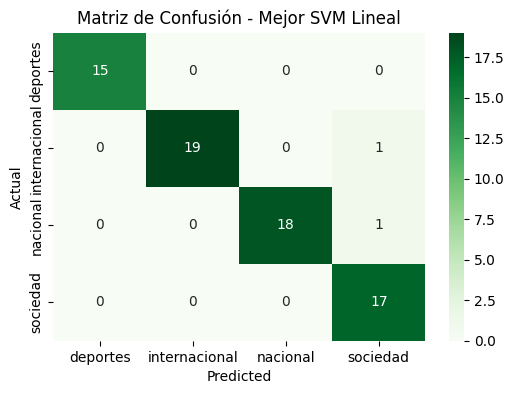

In [55]:
print("\nResultados completos del Grid Search:")

# Nos quedamos con el mejor modelo encontrado
best_linear_svc_model = linearsvc_grid.best_estimator_

# Ejecutamos las predicciones con el mejor modelo encontrado
best_linearsvc_predictions = best_linear_svc_model.predict(test_documentos_procesados)

# Evaluamos el rendimiento del mejor modelo encontrado (multiclase)
best_accuracy = accuracy_score(test_df['Categoría'], best_linearsvc_predictions)
best_precision = precision_score(test_df['Categoría'], best_linearsvc_predictions, average='macro', zero_division=0)
best_recall = recall_score(test_df['Categoría'], best_linearsvc_predictions, average='macro', zero_division=0)
best_f1 = f1_score(test_df['Categoría'], best_linearsvc_predictions, average='macro', zero_division=0)

print("\nEvaluación del mejor modelo SVM Lineal en el conjunto de test:")
print(f"Exactitud (Accuracy): {best_accuracy:.4f}")
print(f"Precisión (Precision): {best_precision:.4f}")
print(f"Exhaustividad (Recall): {best_recall:.4f}")
print(f"Puntuación F1 (F1 Score): {best_f1:.4f}")

print("\nReporte de clasificación del mejor modelo:")
print(classification_report(test_df['Categoría'], best_linearsvc_predictions, zero_division=0))

# Muestra la matriz de confusión del mejor modelo
best_conf_matrix = confusion_matrix(test_df['Categoría'], best_linearsvc_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=best_linear_svc_model.classes_,
            yticklabels=best_linear_svc_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Mejor SVM Lineal')
plt.show()


# Regresión logística para clasificación de noticias periodísticas

In [20]:
# Configuración del modelo de Regresión Logística
logreg_model = LogisticRegression(
    solver='saga',              # Algoritmo de optimización
    penalty='elasticnet',       # Combinación de L1 y L2
    l1_ratio=0.5,               # Proporción de L1 (1.0 = Lasso, 0.0 = Ridge)
    C=1.0,                      # Fuerza de regularización
    class_weight='balanced',          # Manejo del desbalanceo
    max_iter=1000,              # Máximo de iteraciones
    tol=1e-4,                   # Tolerancia de convergencia
    random_state=RANDOM_SEED
)

# Pipeline con TF-IDF + Regresión Logística
logreg_pipeline = Pipeline(
    steps=[
        ('tfidf', tfidf_vectorizer),
        ('clf', logreg_model)
    ]
)

# Entrenamiento del modelo
logreg_pipeline.fit(
    train_documentos_procesados,
    train_df['Categoría']     
)


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5)),
                ('clf',
                 LogisticRegression(class_weight='balanced', l1_ratio=0.5,
                                    max_iter=1000, penalty='elasticnet',
                                    random_state=202510, solver='saga'))])

In [21]:
# Guarda el pipeline completo en un archivo para su uso posterior
joblib.dump(logreg_pipeline, 'logreg_spam_pipeline_clean.joblib')
print("Pipeline de Regresión Logística entrenado y guardado como 'logreg_spam_pipeline_clean.joblib'")

Pipeline de Regresión Logística entrenado y guardado como 'logreg_spam_pipeline_clean.joblib'


Número de documentos de test procesados: 71
Documentos de test procesados: ['selección hockey hielo canadá ganar copa mundial tras vencer rusia canadá coronar campeón gol connor mcdavid minuto victoria recibido entusiasmo aficionado canadiense', 'gobierno brasil anunciar plan desarrollo urbano sostenible incluir construcción parqu verde transporte público vivienda asequible', 'importancia educación inclusivo estudiante discapacidad programa inclusión escolar mejorado rendimiento académico integración social alumno necesidad especial']...
Pipeline cargado correctamente.

Evaluación del modelo de Regresión Logística en el conjunto de test:
Exactitud (Accuracy): 0.9577
Precisión (Precision - macro): 0.9634
Exhaustividad (Recall - macro): 0.9605
Puntuación F1 (F1 Score - macro): 0.9595

Reporte de clasificación:
               precision    recall  f1-score   support

     deportes       1.00      1.00      1.00        15
internacional       0.91      1.00      0.95        20
     nacional 

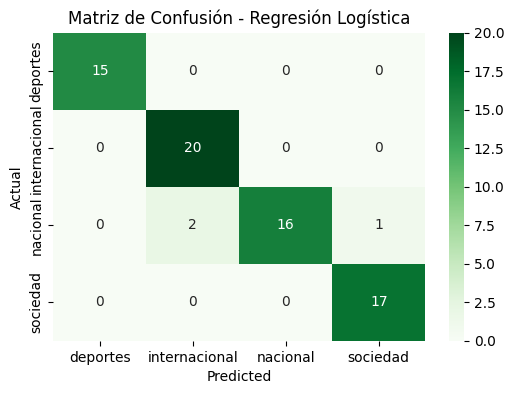

Número de fallos en las predicciones: 3


,Titular,Cuerpo,Categoría,longitud_titular,longitud_cuerpo,texto_completo,predicted
174,Presidente anuncia nuevo plan de infraestructu...,El presidente Juan Pérez anunció el lunes un a...,nacional,7,66,Presidente anuncia nuevo plan de infraestructu...,internacional
181,Autoridades locales critican falta de apoyo es...,Algunas autoridades municipales denunciaron la...,nacional,7,27,Autoridades locales critican falta de apoyo es...,sociedad
223,Presidente anuncia plan de apoyo a la economía...,Se lanzó una iniciativa estatal para fomentar ...,nacional,9,25,Presidente anuncia plan de apoyo a la economía...,internacional


In [22]:
# Preprocesamos los documentos del conjunto de test
test_documentos_procesados = []
for i, fila in test_df.iterrows():
    texto_combinado = f"{fila['Titular']} {fila['Cuerpo']}"
    tokens = preprocesar_documento(texto_combinado)
    test_documentos_procesados.append(" ".join(tokens))

# Número de documentos de test procesados
print(f"Número de documentos de test procesados: {len(test_documentos_procesados)}")
print(f"Documentos de test procesados: {test_documentos_procesados[:3]}...")


# Carga el pipeline guardado desde el archivo
logreg_loaded_pipeline = joblib.load('logreg_spam_pipeline.joblib')
print("Pipeline cargado correctamente.")


# Predicciones
predicciones = logreg_loaded_pipeline.predict(test_documentos_procesados)


# Métricas de evaluación
accuracy = accuracy_score(test_df['Categoría'], predicciones)
precision = precision_score(test_df['Categoría'], predicciones, average='macro')   
recall = recall_score(test_df['Categoría'], predicciones, average='macro')         
f1 = f1_score(test_df['Categoría'], predicciones, average='macro')                 

print("\nEvaluación del modelo de Regresión Logística en el conjunto de test:")
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"Precisión (Precision - macro): {precision:.4f}")
print(f"Exhaustividad (Recall - macro): {recall:.4f}")
print(f"Puntuación F1 (F1 Score - macro): {f1:.4f}")

print("\nReporte de clasificación:")
print(classification_report(test_df['Categoría'], predicciones))

# Muestra la matriz de confusión
conf_matrix = confusion_matrix(test_df['Categoría'], predicciones)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels= logreg_loaded_pipeline.classes_,
            yticklabels= logreg_loaded_pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

# Saca los documentos que han fallado y la etiqueta real y la predicha
fallos = test_df[test_df['Categoría'] != predicciones]
print(f"Número de fallos en las predicciones: {fallos.shape[0]}")
display(fallos.assign(predicted= predicciones[test_df['Categoría'] != predicciones]))

In [23]:
# Configuramos el cross validator estratificado
cross_validator = StratifiedKFold(
    n_splits=10,                  # Número de folds
    shuffle=True,                 # Mezclar los datos
    random_state=RANDOM_SEED      # Reproducibilidad
)

# Realiza la validación cruzada
scores = cross_val_score(
    estimator=logreg_pipeline,           # Pipeline RL
    X=train_documentos_procesados,       # Documentos ya preprocesados
    y=train_df['Categoría'],             
    cv=cross_validator,
    scoring='accuracy'
)

# Muestra resultados
print("Resultados de la validación cruzada (accuracy) en el conjunto de entrenamiento:")
for fold_idx, score in enumerate(scores):
    print(f" Fold {fold_idx + 1}: {score:.4f}")

print(f" Precisión media: {scores.mean():.4f} ± {scores.std():.4f}")


Resultados de la validación cruzada (accuracy) en el conjunto de entrenamiento:
 Fold 1: 0.9655
 Fold 2: 0.9655
 Fold 3: 0.9310
 Fold 4: 0.9286
 Fold 5: 0.9286
 Fold 6: 0.8571
 Fold 7: 0.9286
 Fold 8: 0.9643
 Fold 9: 0.9286
 Fold 10: 0.8929
 Precisión media: 0.9291 ± 0.0322


In [24]:
# Especificamos los hiper parámetros a ajustar en el GridSearchCV
param_grid_2 = {
    'tfidf__max_features': [500, 1000, 1271],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'clf__l1_ratio': [0.1, 0.5, 0.9],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__tol': [1e-4, 1e-3, 1e-2],
    'clf__max_iter': [1000, 2000, 5000, 10000],
    'clf__class_weight': [None, 'balanced']
}

# Configurar GridSearchCV
logreg_grid = GridSearchCV(
    estimator=logreg_pipeline, 
    param_grid=param_grid_2,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    verbose=2
)

# Ejecuta el ajuste del modelo con el GridSearchCV
start_time = pd.Timestamp.now()
logreg_grid.fit(
    train_documentos_procesados,
    train_df['Categoría']     
)
end_time = pd.Timestamp.now()

print(f"Tiempo de ejecución del GridSearchCV: {(end_time - start_time).total_seconds()} segundos")

print("Mejores hiper-parámetros encontrados:")
best_parms = pd.Series(logreg_grid.best_params_)
display(best_parms)

print(f"Mejor puntuación de validación cruzada: {logreg_grid.best_score_:.4f}")


Fitting 10 folds for each of 3240 candidates, totalling 32400 fits
Tiempo de ejecución del GridSearchCV: 954.002694 segundos
Mejores hiper-parámetros encontrados:


clf__C                    100
clf__class_weight        None
clf__l1_ratio             0.5
clf__max_iter            1000
clf__tol               0.0001
tfidf__max_features      1271
tfidf__ngram_range     (1, 2)
dtype: object

Mejor puntuación de validación cruzada: 0.9719



Resultados completos del Grid Search:

Evaluación del mejor modelo de Regresión Logística en el conjunto de test:
Exactitud (Accuracy): 0.9577
Precisión (Precision - macro): 0.9597
Exhaustividad (Recall - macro): 0.9612
Puntuación F1 (F1 Score - macro): 0.9601

Reporte de clasificación del mejor modelo:
               precision    recall  f1-score   support

     deportes       1.00      1.00      1.00        15
internacional       0.95      0.95      0.95        20
     nacional       0.94      0.89      0.92        19
     sociedad       0.94      1.00      0.97        17

     accuracy                           0.96        71
    macro avg       0.96      0.96      0.96        71
 weighted avg       0.96      0.96      0.96        71



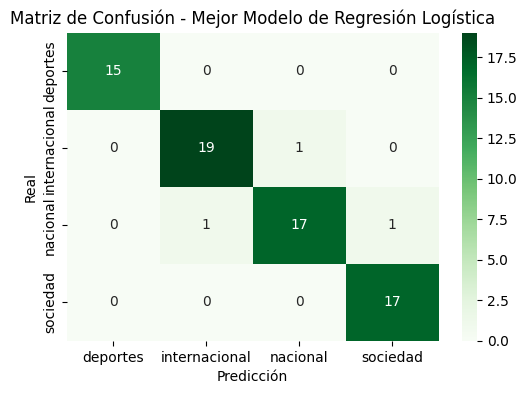

In [63]:
print("\nResultados completos del Grid Search:")

# Nos quedamos con el mejor modelo encontrado
best_logreg_model = logreg_grid.best_estimator_

# Ejecutamos las predicciones con el mejor modelo encontrado
best_logreg_predictions = best_logreg_model.predict(test_documentos_procesados)

# Evaluamos el rendimiento del mejor modelo encontrado
best_accuracy = accuracy_score(test_df['Categoría'], best_logreg_predictions)
best_precision = precision_score(test_df['Categoría'], best_logreg_predictions, average='macro')
best_recall = recall_score(test_df['Categoría'], best_logreg_predictions, average='macro')
best_f1 = f1_score(test_df['Categoría'], best_logreg_predictions, average='macro')

print("\nEvaluación del mejor modelo de Regresión Logística en el conjunto de test:")
print(f"Exactitud (Accuracy): {best_accuracy:.4f}")
print(f"Precisión (Precision - macro): {best_precision:.4f}")
print(f"Exhaustividad (Recall - macro): {best_recall:.4f}")
print(f"Puntuación F1 (F1 Score - macro): {best_f1:.4f}")

print("\nReporte de clasificación del mejor modelo:")
print(classification_report(test_df['Categoría'], best_logreg_predictions))

best_conf_matrix = confusion_matrix(test_df['Categoría'], best_logreg_predictions)

etiquetas = best_logreg_model.named_steps['clf'].classes_

plt.figure(figsize=(6, 4))
sns.heatmap(
    best_conf_matrix,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=etiquetas,
    yticklabels=etiquetas
)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Mejor Modelo de Regresión Logística')
plt.show()


# Conclusiones

## Naive Bayes Multinomial con representación por conteo (BoW)

### Ajuste de pesos de las clases en Naive Bayes

En el caso del clasificador **Naive Bayes Multinomial**, además de repetir los experimentos con el dataset desbalanceado, se probó una variante en la que se ajustan explícitamente los **pesos de las clases (priors)** para estudiar el efecto del desbalance en el modelo.

En el código “normal” con el dataset desbalanceado se utiliza la configuración por defecto:

```python
clf_count_full = MultinomialNB(
    alpha=1.0,
    force_alpha=True,
    fit_prior=True,
    class_prior=None,
)
```

Con estos parámetros, el modelo **aprende automáticamente las probabilidades a priori de cada clase** a partir de los datos (`fit_prior=True`), de modo que:

* Las clases más frecuentes en el entrenamiento (por ejemplo, *internacional*) reciben un **prior más alto**.
* Las clases menos representadas (como *deportes*) tienen un prior más bajo.

Es decir, el modelo parte de la idea de que, **antes de ver el texto**, es más probable que una noticia sea de una sección mayoritaria que de una minoritaria, y eso influye en la decisión final cuando la evidencia textual no es muy clara.

En la versión con **ajuste de pesos**, se modifica este comportamiento:

```python
clases_unicas = np.unique(y_train)
n_clases = len(clases_unicas)
priors_uniformes = np.ones(n_clases) / n_clases  # todas las clases igual de probables

clf_count_full = MultinomialNB(
    alpha=1.0,
    force_alpha=True,
    fit_prior=False,          # no aprende los priors de los datos
    class_prior=priors_uniformes  # priors fijos, todos iguales
)
```

Aquí se desactiva el aprendizaje automático de los priors (`fit_prior=False`) y se fijan manualmente unas **probabilidades a priori uniformes** (`class_prior = [1/K, …, 1/K]`). Esto significa que el modelo **deja de favorecer a las clases más frecuentes** y asume que todas las secciones del periódico son igual de probables a priori, independientemente de cuántos ejemplos tenga cada una en el conjunto de entrenamiento.

En la práctica, este ajuste de pesos sirve para:

* **Compensar parcialmente el desbalance de clases** sin tocar el dataset (sin oversampling ni undersampling).
* Hacer que la decisión del modelo dependa **más de las palabras del documento** (las verosimilitudes (P(w\mid c))) y menos de la frecuencia global de cada categoría.
* Potencialmente, **mejorar el trato a las clases minoritarias** (por ejemplo, evitando que el modelo “se vaya” por defecto a la clase mayoritaria cuando la evidencia es ambigua), y con ello equilibrar un poco las métricas por clase (recall y F1 de la clase minoritaria).

En resumen, el nuevo código de ajuste de pesos cambia la forma en que Naive Bayes combina la información del texto con la información de la distribución de clases: en lugar de “creer” lo que dice el desbalance del dataset, se fuerza a que **todas las clases partan del mismo punto de salida**, permitiendo estudiar si el desbalance estaba influyendo en las predicciones y, en su caso, si este reequilibrio mejora la calidad de la clasificación en alguna de las secciones.


### Efecto del ajuste de pesos en Naive Bayes

Al comparar los resultados con el modelo original (que aprendía los priors del dataset desbalanceado), se observa que las **métricas son exactamente las mismas**:

* Accuracy: **0,9859**
* F1-macro: **0,9872**
* Misma matriz de confusión (1 solo error en 71 noticias)
* Mismo top de palabras más y menos frecuentes.

Es decir, en este problema concreto el ajuste de los pesos de las clases **no modifica el comportamiento del modelo**. Esto sugiere que:

1. El **desbalance entre secciones es moderado**, por lo que las diferencias en los priors no son extremas.
2. La decisión de Naive Bayes está dominada sobre todo por la **información léxica** (las probabilidades de las palabras dado cada clase), que es muy discriminativa, especialmente para categorías como *Deportes* y *Sociedad*.

En conjunto, el experimento muestra que, para este dataset, **forzar priors uniformes no aporta una mejora adicional**, ya que el modelo ya clasifica casi perfectamente las noticias incluso utilizando los priors aprendidos a partir de la distribución real de las clases.


## Naive Bayes Multinomial TF-IDF

El **mismo procedimiento** que se utilizó en **Naive Bayes** por conteo para tratar el desbalanceo de clases se aplicó también al modelo de Naive Bayes con representación **TF-IDF**: se comparó la versión que aprende automáticamente los priors a partir de la frecuencia de cada categoría (fit_prior=True) con otra en la que se fijan priors uniformes para todas las clases (fit_prior=False, class_prior iguales).

Al comparar el modelo **Naive Bayes con TF-IDF** usando los priors aprendidos del dataset desbalanceado con la variante en la que se imponen **priors uniformes** para todas las clases, se observa que la *accuracy* (0,9577) y el **F1-macro** (~0,96) se mantienen prácticamente iguales, pero la **distribución de los errores entre clases cambia ligeramente**.

Con priors aprendidos, la mayoría de los fallos se concentraban en las clases *Internacional* y, sobre todo, *Sociedad* (por ejemplo, noticias de Sociedad clasificadas como Nacional). Al imponer priors uniformes, el modelo sigue cometiendo solo 3 errores sobre 71 noticias, pero estos se reparten de forma algo diferente entre *Nacional* y *Sociedad*: mejora ligeramente el comportamiento en una de las clases a costa de empeorar mínimamente en otra.

En conjunto, esto indica que el ajuste de los priors con TF-IDF **no modifica el rendimiento global del modelo**, pero sí puede producir pequeños cambios en qué clases “pagan” los errores. El clasificador sigue siendo muy robusto frente al desbalance moderado del dataset, y el uso de priors uniformes actúa más como una forma de redistribuir ligeramente las confusiones entre secciones que como un mecanismo para mejorar de forma clara las métricas agregadas.


## Random forest

En el caso de **Random Forest**, se probaron distintas estrategias de ponderación de clases para evaluar el impacto del desbalanceo. El modelo original, con `class_weight=None`, ya ofrecía un rendimiento muy alto (accuracy y F1-macro ≈ 0,97), y al repetir el entrenamiento con `class_weight='balanced'` los resultados fueron **prácticamente idénticos**, lo que indica que el desbalance moderado del dataset no afecta de forma apreciable al comportamiento del bosque de árboles.

Posteriormente, al incluir `class_weight` dentro del **GridSearch**, el mejor modelo encontrado utilizó `class_weight='balanced_subsample'`. Esta variante mantiene la misma estabilidad que los modelos anteriores, pero consigue una **ligera mejora** en las métricas (manteniendo accuracy 0,9718 y aumentando ligeramente las medias macro y weighted), por lo que puede considerarse la configuración más adecuada de Random Forest en este trabajo. En resumen, los tres modelos rinden de forma muy similar, y las diferencias entre ellos son sutiles, pero `balanced_subsample` permite exprimir un poco más el rendimiento sin perder robustez frente al desbalanceo.


## SVM

Al repetir los experimentos con una SVM lineal incluyendo `class_weight='balanced'` en el espacio de búsqueda, **GridSearchCV selecciona un conjunto de hiperparámetros distinto** (por ejemplo, otro valor de `C` y función de pérdida), pero el modelo resultante obtiene **exactamente las mismas métricas en el conjunto de test** que la SVM sin ponderación de clases (accuracy y F1 ≈ 0,97), con una matriz de confusión idéntica. Esto indica que, en este problema concreto, la SVM lineal es muy robusta al desbalance moderado del dataset y que la reponderación automática de las clases apenas modifica la frontera de decisión aprendida, pudiéndose alcanzar el mismo rendimiento con configuraciones de hiperparámetros ligeramente diferentes.


## Regresión logística

En el caso de la **Regresión Logística**, se evaluó también el impacto del desbalanceo de clases incorporando `class_weight='balanced'` tanto en el modelo básico como en el espacio de búsqueda de GridSearchCV. Sin embargo, los resultados muestran que el algoritmo es especialmente **insensible al desbalance moderado** de este dataset:

* El mejor modelo obtenido por GridSearchCV coincide exactamente con el que se obtiene sin ponderación de clases (`class_weight=None`), reutilizando los mismos hiperparámetros óptimos (`C=100`, `l1_ratio=0,5`, `tfidf__max_features=1271`, `tfidf__ngram_range=(1,2)`, etc.).
* En el conjunto de test se alcanzan las mismas métricas: **accuracy = 0,9577**, **F1-macro ≈ 0,96** y una matriz de confusión idéntica, con clasificación perfecta en *Deportes* y muy buen rendimiento en el resto de secciones.

Esto indica que, para esta tarea y con esta representación TF-IDF, la Regresión Logística ya está capturando correctamente la estructura de las cuatro clases y que la reponderación automática de las mismas **no aporta mejoras adicionales**, confirmando su robustez frente al desbalanceo presente en los datos.


## Conclusiones finales

| Modelo                         | Representación         | Accuracy | F1-macro |
|--------------------------------|------------------------|----------|----------|
| Naive Bayes (Multinomial)      | Conteo (BoW)           | 0.9859   | 0.9872   |
| Random Forest                  | TF-IDF (balanced_subsample) | 0.9718   | 0.9729   |
| SVM lineal (LinearSVC)         | TF-IDF                 | 0.9718   | 0.9729   |
| Regresión Logística            | TF-IDF                 | 0.9577   | 0.9601   |
| Naive Bayes (Multinomial)      | TF-IDF                 | 0.9577   | 0.9596   |


* El **mejor modelo global** con el dataset desbalanceado es **Naive Bayes por conteo**, que roza el 99 % de F1-macro y apenas comete 1–2 errores en todo el conjunto de test. Esto confirma que, con un vocabulario sencillo y clases bien separadas, un modelo probabilístico muy simple puede ser **extraordinariamente efectivo**.

* Los modelos más complejos basados en TF-IDF (**Random Forest, SVM lineal y Regresión Logística**) también ofrecen un **rendimiento muy alto** (F1-macro ≥ 0,96), pero ninguno logra superar al Naive Bayes por conteo. Sirven más para confirmar la estabilidad del problema que para mejorar realmente las métricas.

* El **desbalanceo es moderado** (74–99 ejemplos por clase), y se ha comprobado que:

  * Ajustar **priors uniformes** en Naive Bayes (conteo y TF-IDF) casi **no cambia las métricas**: la accuracy y el F1-macro varían solo en milésimas, y las matrices de confusión son muy similares.
  * En **Random Forest**, pasar de `class_weight=None` a `balanced` y luego a `balanced_subsample` apenas modifica el rendimiento (siempre alrededor de 0,97 en F1-macro). 
  * En **SVM lineal**, incluir `class_weight='balanced'` hace que GridSearch encuentre **otros hiperparámetros**, pero el modelo resultante obtiene **exactamente las mismas métricas y la misma matriz de confusión** que sin ponderación.
  * En **Regresión Logística**, el efecto es aún más claro: aunque se añade `class_weight='balanced'` al GridSearch, el mejor modelo sigue siendo el mismo con `class_weight=None`, lo que indica una **robustez total** frente a este nivel de desbalance.

* En todos los modelos, los pocos errores que aparecen se concentran casi siempre en la clase **Nacional**, que a veces se confunde con **Internacional** o **Sociedad**, mientras que **Deportes** se clasifica perfecta en todos los casos.

Tratar el desbalanceo (via `class_weight` o priors uniformes) tiene un **impacto muy limitado** en este problema, porque las clases ya están bastante bien separadas por el contenido textual. Todos los clasificadores alcanzan un rendimiento muy alto, y el modelo más simple, **Naive Bayes con bolsa de palabras**, resulta ser el que mejor explota la estructura del dataset, convirtiéndose en la opción recomendada como clasificador final.


| Modelo                    | Escenario     | Representación (vectorizador)                                     | Hiperparámetros clave del clasificador                                                                                                                                                                                       | Comentario sobre resultados                                                                                            |
| ------------------------- | ------------- | ----------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------- |
| Naive Bayes (Multinomial) | NO-REPETICIÓN | `CountVectorizer()` (BoW, parámetros por defecto)                 | `MultinomialNB(alpha=1.0, force_alpha=True, fit_prior=True, class_prior=None)`                                                                                                                                               | Aprende los priors de los datos desbalanceados. Accuracy = 0.9859, F1-macro = 0.9872.                                  |
| Naive Bayes (Multinomial) | PESOS         | `CountVectorizer()`                                               | `MultinomialNB(alpha=1.0, force_alpha=True, fit_prior=False, class_prior=[0.25,0.25,0.25,0.25])`                                                                                                                             | Priors uniformes. **Mismas métricas** que sin pesos (accuracy y F1-macro idénticos → misma matriz de confusión).       |
| Naive Bayes (Multinomial) | NO-REPETICIÓN | `TfidfVectorizer()` (parámetros por defecto)                      | `MultinomialNB(alpha=1.0, force_alpha=True, fit_prior=True, class_prior=None)`                                                                                                                                               | Priors aprendidos del dataset. Accuracy = 0.9577, F1-macro = 0.9597.                                                   |
| Naive Bayes (Multinomial) | PESOS         | `TfidfVectorizer()`                                               | `MultinomialNB(alpha=1.0, force_alpha=True, fit_prior=False, class_prior=[0.25,0.25,0.25,0.25])`                                                                                                                             | Priors uniformes. Accuracy = 0.9577, F1-macro ≈ 0.9596. Métricas casi idénticas, pero matriz de confusión cambia algo. |
| Random Forest             | NO-REPETICIÓN | `TfidfVectorizer(max_df=0.5, ngram_range=(1,1), analyzer='word')` | `RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, max_features='sqrt', min_samples_split=4, min_samples_leaf=2, min_impurity_decrease=0.01, class_weight=None, random_state=RS)`                   | Modelo básico. Accuracy = 0.9718, F1-macro = 0.9729.                                                                   |
| Random Forest             | PESOS         | `TfidfVectorizer(max_df=0.5, ngram_range=(1,1), analyzer='word')` | `RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=50, max_features='sqrt', min_samples_split=4, min_samples_leaf=2, min_impurity_decrease=0.01, class_weight='balanced_subsample', random_state=RS)` | Modelo seleccionado por GridSearch con pesos. **Mismas métricas** (accuracy y F1-macro) que el RF básico.              |
| SVM lineal (LinearSVC)    | NO-REPETICIÓN | `TfidfVectorizer(max_df=0.5, ngram_range=(1,1), analyzer='word')` | `LinearSVC(loss='hinge', C=1.0, tol=1e-4, max_iter=1000, class_weight=None, random_state=RS)`                                                                                                                                | Modelo sin pesos. Accuracy = 0.9718, F1-macro ≈ 0.9729.                                                                |
| SVM lineal (LinearSVC)    | PESOS         | `TfidfVectorizer(max_df=0.5, ngram_range=(1,1), analyzer='word')` | `LinearSVC(loss='hinge', C=0.4, tol=1e-4, max_iter=1000, class_weight='balanced', random_state=RS)`                                                                                                                          | Modelo con `class_weight='balanced'`. **Predicciones idénticas** al modelo sin pesos → mismas métricas y confusión.    |
| Regresión Logística       | NO-REPETICIÓN | `TfidfVectorizer(max_features=1271, ngram_range=(1,2))`           | `LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, C=100, tol=1e-4, max_iter=1000, class_weight=None, random_state=RS)`                                                                                  | Accuracy = 0.9577, F1-macro = 0.9601.                                                                                  |
| Regresión Logística       | PESOS         | `TfidfVectorizer(max_features=1271, ngram_range=(1,2))`           | **Mismo modelo**: `LogisticRegression(..., l1_ratio=0.5, C=100, class_weight=None, ...)`                                                                                                                                     | El GridSearch con `class_weight` vuelve a escoger `class_weight=None`. **Mismas métricas y mismo modelo.**             |


Para cada familia de modelos (Naive Bayes, Random Forest, SVM lineal y Regresión Logística) se identificó el mejor conjunto de hiperparámetros tanto en el escenario sin ponderación de clases (NO-REPETICIÓN) como en el escenario con ajuste de priors o class_weight (PESOS). En varios casos, como en Random Forest o SVM lineal, se observa que conjuntos de hiperparámetros distintos producen exactamente el mismo rendimiento en test (misma accuracy, mismo F1-macro y misma matriz de confusión). Este resultado sugiere la existencia de una región amplia de soluciones “equivalentes” en el espacio de hiperparámetros: pequeñas variaciones en C, en la profundidad del bosque o en class_weight no alteran las predicciones finales, dado que el problema está bien condicionado y las clases son relativamente fáciles de separar mediante BoW/TF-IDF.